<h1 style="font-size: 64px">Model for netflix dataset</h1>

<h2 style="font-size: 48px">Importing modules</h2>

In [1]:
#import scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import re
import seaborn as sns
import string
#import collections
#from sklearn.cluster import KMeans
#from textblob import TextBlob
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
#import missingno as msno
#import spacy
#nlp = spacy.load('en_core_web_sm')

stop = stopwords.words('english')

# Load data

1) Add more columns to process (features) : genre, rate (PG-13), type (TV, movie). 2) Compute distance measure separately on different fields. Aggregate result using weighted average with predefined weights. 3) Validate your results based on different weights. Show smth like this: top-n (top-10) most similar movies to movie "No country for old man" based on different weights (show all the columns which were used as features).

In [2]:
df = pd.read_csv("netflix_titles.csv")
df['desc_no_stopwords'] = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['desc_no_stopwords'] = df['desc_no_stopwords'].str.replace('[{}]'.format(string.punctuation), '')
df['title_no_stopwords'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
df['title_no_stopwords'] = df['title_no_stopwords'].str.replace('[{}]'.format(string.punctuation), '')
df["year_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.year).astype("Int64")
df["month_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.month_name())
df["day_added"] = pd.to_datetime(df["date_added"]).apply(lambda x: x.day).astype("Int64")
df

/tmp/ipykernel_4598/956981072.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['desc_no_stopwords'] = df['desc_no_stopwords'].str.replace('[{}]'.format(string.punctuation), '')
/tmp/ipykernel_4598/956981072.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_no_stopwords'] = df['title_no_stopwords'].str.replace('[{}]'.format(string.punctuation), '')


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",As father nears end life filmmaker Kirsten Joh...,Dick Johnson Is Dead,2021,September,25
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",After crossing paths party Cape Town teen sets...,Blood Water,2021,September,24
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,To protect family powerful drug lord skilled t...,Ganglands,2021,September,24
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",Feuds flirtations toilet talk go among incarce...,Jailbirds New Orleans,2021,September,24
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,In city coaching centers known train India’s f...,Kota Factory,2021,September,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",A political cartoonist crime reporter pair cop...,Zodiac,2019,November,20
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",While living alone spooky town young girl befr...,Zombie Dumb,2019,July,1
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,Looking survive world taken zombies dorky coll...,Zombieland,2019,November,1
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",Dragged civilian life former superhero must tr...,Zoom,2020,January,11


In [3]:
df.index = df["title"]

In [4]:
df["year_added"] = df["year_added"].astype("string")
df["month_added"] = df["month_added"].astype("string")
df["day_added"] = df["day_added"].astype("string")

# Prepare data

In [5]:
df["listed_in"] = [i.split(", ") for i in df["listed_in"]]

In [6]:
for j, i in enumerate(df["listed_in"]):
    if df["type"][j] == "TV Show":
        for m, n in enumerate(i):
            if "TV" not in n:
                i.pop(m)
                df["listed_in"][j] = i
    else:
        for m, n in enumerate(i):
            if "TV" in n:
                i.pop(m)
                df["listed_in"][j] = i
    df["listed_in"][j] = ", ".join(df["listed_in"].values[j])

/tmp/ipykernel_4598/707957034.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["listed_in"][j] = ", ".join(df["listed_in"].values[j])
/tmp/ipykernel_4598/707957034.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["listed_in"][j] = i


In [7]:
genres = set()
for i in df["listed_in"].unique():
    genres.update(i.split(", "))
g = set()
for i in genres:
    g.add(i.replace("TV", "").replace(" ", "").replace("Shows", "").replace("Movies", ""))
genres = g
genres.remove("")

In [8]:
release_year = df["release_year"].fillna("").unique()

In [9]:
rating = df["rating"].fillna("").unique()

In [10]:
types = df["type"].unique()

In [11]:
duration = df["duration"].unique()

In [12]:
country = set()
for i in df["country"].fillna("").unique():
    country.update(i.split(", "))
country.remove("")

In [13]:
directors = set()
for i in df["director"].fillna("").unique():
    directors.update(i.split(", "))
directors.remove("")

### No cast. Too much information 36k+ columns

In [14]:
#cast = set()
#for i in df["cast"].fillna("").unique():
#    cast.update(i.split(", "))

In [15]:
#df_cast = pd.DataFrame(index=df["title"], columns=list(cast)).fillna(0)
#for x in df_cast.columns:
#    df_cast[x] = (df["cast"].str.find(x) > -1).astype("int64")
#df_cast[""] = (df_cast[""] < 1).astype("int64")

In [16]:
df_type = pd.DataFrame(index=df["title"], columns=types).fillna(0)
for x in df_type.columns:
    df_type[x] = (df["type"] == x).astype("int64")

In [17]:
df_directors = pd.DataFrame(index=df["title"], columns=list(directors)).fillna(0)
for x in df_directors.columns:
    df_directors[x] = (df["director"].str.find(x) > -1).astype("int64")
df_directors[""] = 0
df_directors[""].loc[df_directors.where(df_directors.T.sum() == 0).dropna().index] = 1

/tmp/ipykernel_4598/1162822588.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_directors[""] = 0


In [18]:
df_country = pd.DataFrame(index=df["title"], columns=list(country)).fillna(0)
for x in df_country.columns:
    df_country[x] = (df["country"].str.find(x) > -1).astype("int64")
df_country[""] = 0
df_country[""].loc[df_country.where(df_country.T.sum() == 0).dropna().index] = 1

/tmp/ipykernel_4598/3008291725.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_country[""] = 0


In [19]:
df_release_year = pd.DataFrame(index=df["title"], columns=release_year).fillna(0)
for x in df_release_year.columns:
    df_release_year[x] = (df["release_year"] == x).astype("int64")

In [20]:
df_rating = pd.DataFrame(index=df["title"], columns=rating).fillna(0)
for x in df_rating.columns:
    df_rating[x] = (df["rating"] == x).astype("int64")
df_rating[""] = 0
df_rating[""].loc[df_rating.where(df_rating.T.sum() == 0).dropna().index] = 1

In [21]:
df_duration_minutes = pd.DataFrame(df["duration"].mask(df["type"] == "TV Show").dropna().str.strip(" min").astype("int32", errors='raise'), index=df["title"]).fillna(0)

In [22]:
df_duration_seasons = pd.DataFrame(df["duration"].mask(df["type"] == "Movie").dropna().str.strip(" Season").astype("int32", errors='raise'), index=df["title"]).fillna(0)

In [23]:
df_genres = pd.DataFrame(index=df["title"], columns=list(genres)).fillna(0)
for x in df_genres.columns:
    df_genres[x] = (df["listed_in"].str.replace("TV", "").str.replace(" ", "").str.replace("Shows", "").str.replace("Movies", "").str.find(x) > -1).astype("int64").values
df_genres[""] = 0
df_genres[""].loc[df_genres.where(df_genres.T.sum() == 0).dropna().index] = 1

In [24]:
df_year_added = pd.DataFrame(index=df["title"], columns=df['year_added'].fillna("").unique()).fillna(0)
for x in df_year_added.columns:
    df_year_added[x] = (df["year_added"] == x).fillna(False).astype("int64")
df_year_added[""] = 0
df_year_added[""].loc[df_year_added.where(df_year_added.T.sum() == 0).dropna().index] = 1

In [25]:
df_month_added = pd.DataFrame(index=df["title"], columns=df['month_added'].fillna("").unique()).fillna(0)
for x in df_month_added.columns:
    df_month_added[x] = (df["month_added"] == x).fillna(False).astype("int64")
df_month_added[""] = 0
df_month_added[""].loc[df_month_added.where(df_month_added.T.sum() == 0).dropna().index] = 1

In [26]:
df_day_added = pd.DataFrame(index=df["title"], columns=df['day_added'].fillna("").unique()).fillna(0)
for x in df_day_added.columns:
    df_day_added[x] = (df["day_added"] == x).fillna(False).astype("int64")
df_day_added[""] = 0
df_day_added[""].loc[df_day_added.where(df_day_added.T.sum() == 0).dropna().index] = 1

# WRITE CSV

## No ngram_range --- 300k+ columns

In [4]:
vdes = TfidfVectorizer()
vtit = TfidfVectorizer()
des = vdes.fit_transform(df['desc_no_stopwords'].fillna(""))
tit = vtit.fit_transform(df['title_no_stopwords'].fillna(""))

### Write csv

In [106]:
df_type.T.corr().to_csv("models/corr/type_correlation.csv")
df_directors.T.corr().to_csv("models/corr/directors_correlation.csv")
df_country.T.corr().to_csv("models/corr/country_correlation.csv")
df_release_year.T.corr().to_csv("models/corr/release_year_correlation.csv")
df_rating.T.corr().to_csv("models/corr/rating_correlation.csv")
df_genres.T.corr().to_csv("models/corr/genres_correlation.csv")
df_year_added.T.corr().to_csv("models/corr/year_added_correlation.csv")
df_month_added.T.corr().to_csv("models/corr/month_added_correlation.csv")
df_day_added.T.corr().to_csv("models/corr/day_added_correlation.csv")
pd.DataFrame(des.toarray(), columns=vdes.get_feature_names_out(), index=df["title"]).T.corr().to_csv("models/corr/description_correlation.csv")
pd.DataFrame(tit.toarray(), columns=vtit.get_feature_names_out(), index=df["title"]).T.corr().to_csv("models/corr/title_correlation.csv")

In [39]:
pd.DataFrame(cosine_similarity(df_type), index=df["title"], columns=df["title"]).to_csv("models/cosine/type_cosine.csv")
pd.DataFrame(cosine_similarity(df_directors), index=df["title"], columns=df["title"]).to_csv("models/cosine/directors_cosine.csv")
pd.DataFrame(cosine_similarity(df_country), index=df["title"], columns=df["title"]).to_csv("models/cosine/country_cosine.csv")
pd.DataFrame(cosine_similarity(df_release_year), index=df["title"], columns=df["title"]).to_csv("models/cosine/release_year_cosine.csv")
pd.DataFrame(cosine_similarity(df_rating), index=df["title"], columns=df["title"]).to_csv("models/cosine/rating_cosine.csv")
pd.DataFrame(cosine_similarity(df_genres), index=df["title"], columns=df["title"]).to_csv("models/cosine/genres_cosine.csv")
pd.DataFrame(cosine_similarity(df_year_added), index=df["title"], columns=df["title"]).to_csv("models/cosine/year_added_cosine.csv")
pd.DataFrame(cosine_similarity(df_month_added), index=df["title"], columns=df["title"]).to_csv("models/cosine/month_added_cosine.csv")
pd.DataFrame(cosine_similarity(df_day_added), index=df["title"], columns=df["title"]).to_csv("models/cosine/day_added_cosine.csv")
pd.DataFrame(cosine_similarity(des.toarray()), index=df["title"], columns=df["title"]).to_csv("models/cosine/description_cosine.csv")
pd.DataFrame(cosine_similarity(tit.toarray()), index=df["title"], columns=df["title"]).to_csv("models/cosine/title_cosine.csv")

In [40]:
pd.DataFrame(euclidean_distances(df_type), index=df["title"], columns=df["title"]).to_csv("models/euclide/type_euclide.csv")
pd.DataFrame(euclidean_distances(df_directors), index=df["title"], columns=df["title"]).to_csv("models/euclide/directors_euclide.csv")
pd.DataFrame(euclidean_distances(df_country), index=df["title"], columns=df["title"]).to_csv("models/euclide/country_euclide.csv")
pd.DataFrame(euclidean_distances(df_release_year), index=df["title"], columns=df["title"]).to_csv("models/euclide/release_year_euclide.csv")
pd.DataFrame(euclidean_distances(df_rating), index=df["title"], columns=df["title"]).to_csv("models/euclide/rating_euclide.csv")
pd.DataFrame(euclidean_distances(df_genres), index=df["title"], columns=df["title"]).to_csv("models/euclide/genres_euclide.csv")
pd.DataFrame(euclidean_distances(df_year_added), index=df["title"], columns=df["title"]).to_csv("models/euclide/year_added_euclide.csv")
pd.DataFrame(euclidean_distances(df_month_added), index=df["title"], columns=df["title"]).to_csv("models/euclide/month_added_euclide.csv")
pd.DataFrame(euclidean_distances(df_day_added), index=df["title"], columns=df["title"]).to_csv("models/euclide/day_added_euclide.csv")
pd.DataFrame(euclidean_distances(des.toarray()), index=df["title"], columns=df["title"]).to_csv("models/euclide/description_euclide.csv")
pd.DataFrame(euclidean_distances(tit.toarray()), index=df["title"], columns=df["title"]).to_csv("models/euclide/title_euclide.csv")

# Checking idf weights of description and titles

In [32]:
idf_desc_df = pd.DataFrame(vdes.idf_, 
                           index=vdes.get_feature_names_out(),
                           columns=['idf_weigths'])
    
idf_desc_df.sort_values(by=['idf_weigths'])

,idf_weigths
life,3.442234
when,3.460679
young,3.494489
new,3.567223
in,3.574647
...,...
chaldea,9.390268
medically,9.390268
medication,9.390268
megazords,9.390268


In [36]:
idf_desc_df = pd.DataFrame(vtit.idf_, 
                           index=vtit.get_feature_names_out(),
                           columns=['idf_weigths'])
    
idf_desc_df.sort_values(by=['idf_weigths'])

,idf_weigths
the,2.758267
love,4.953517
my,5.141773
you,5.676696
man,5.688967
...,...
herederos,9.390268
henrys,9.390268
heneral,9.390268
hen,9.390268


# Read csv and play around with distance based model a little

description == maximum

In [27]:
weights = [{"type": 7, "directors": 3, "country": 4, "release_year": 8, "rating": 2, 
            "genre": 9, "date_added": 1, "description": 6, "title": 5, "sum": 45},
           {"type": 6, "directors": 1, "country": 5, "release_year": 4, "rating": 2, 
            "genre": 7, "date_added": 1, "description": 3, "title": 7, "sum": 36},
           {"type": 4, "directors": 3, "country": 6, "release_year": 6, "rating": 2, 
            "genre": 7, "date_added": 1, "description": 5, "title": 5, "sum": 39},
           {"type": 1, "directors": 1, "country": 1, "release_year": 1, "rating": 1, 
            "genre": 1, "date_added": 1, "description": 10, "title": 1, "sum": 18}]

In [28]:
model = (pd.read_csv("models/corr/type_correlation.csv").set_index("title") * weights[0]["type"] +\
                pd.read_csv("models/corr/directors_correlation.csv").set_index("title") * weights[0]["directors"] +\
                pd.read_csv("models/corr/country_correlation.csv").set_index("title") * weights[0]["country"] +\
                pd.read_csv("models/corr/release_year_correlation.csv").set_index("title") * weights[0]["release_year"] +\
                pd.read_csv("models/corr/rating_correlation.csv").set_index("title") * weights[0]["rating"] +\
                pd.read_csv("models/corr/genres_correlation.csv").set_index("title") * weights[0]["genre"] +\
                (pd.read_csv("models/corr/year_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/month_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/day_added_correlation.csv").set_index("title")) / 3 * weights[0]["date_added"] +\
                pd.read_csv("models/corr/description_correlation.csv").set_index("title") * weights[0]["description"] +\
                pd.read_csv("models/corr/title_correlation.csv").set_index("title") * weights[0]["title"]) / weights[0]["sum"]

In [29]:
model.to_csv("models/weighted models/model_1_corr.csv")

In [30]:
model = (pd.read_csv("models/cosine/type_cosine.csv").set_index("title") * weights[0]["type"] +\
                  pd.read_csv("models/cosine/directors_cosine.csv").set_index("title") * weights[0]["directors"] +\
                  pd.read_csv("models/cosine/country_cosine.csv").set_index("title") * weights[0]["country"] +\
                  pd.read_csv("models/cosine/release_year_cosine.csv").set_index("title") * weights[0]["release_year"] +\
                  pd.read_csv("models/cosine/rating_cosine.csv").set_index("title") * weights[0]["rating"] +\
                  pd.read_csv("models/cosine/genres_cosine.csv").set_index("title") * weights[0]["genre"] +\
                  (pd.read_csv("models/cosine/year_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/month_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/day_added_cosine.csv").set_index("title")) / 3 * weights[0]["date_added"] +\
                  pd.read_csv("models/cosine/description_cosine.csv").set_index("title") * weights[0]["description"] +\
                  pd.read_csv("models/cosine/title_cosine.csv").set_index("title") * weights[0]["title"]) / weights[0]["sum"]

In [31]:
model.to_csv("models/weighted models/model_1_cosine.csv")

In [32]:
model = (pd.read_csv("models/euclide/type_euclide.csv").set_index("title") * weights[0]["type"] +\
                   pd.read_csv("models/euclide/directors_euclide.csv").set_index("title") * weights[0]["directors"] +\
                   pd.read_csv("models/euclide/country_euclide.csv").set_index("title") * weights[0]["country"] +\
                   pd.read_csv("models/euclide/release_year_euclide.csv").set_index("title") * weights[0]["release_year"] +\
                   pd.read_csv("models/euclide/rating_euclide.csv").set_index("title") * weights[0]["rating"] +\
                   pd.read_csv("models/euclide/genres_euclide.csv").set_index("title") * weights[0]["genre"] +\
                   (pd.read_csv("models/euclide/year_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/month_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/day_added_euclide.csv").set_index("title")) / 3 * weights[0]["date_added"] +\
                   pd.read_csv("models/euclide/description_euclide.csv").set_index("title") * weights[0]["description"] +\
                   pd.read_csv("models/euclide/title_euclide.csv").set_index("title") * weights[0]["title"]) / weights[0]["sum"]

In [33]:
model.to_csv("models/weighted models/model_1_euclide.csv")

In [34]:
model = (pd.read_csv("models/corr/type_correlation.csv").set_index("title") * weights[1]["type"] +\
                pd.read_csv("models/corr/directors_correlation.csv").set_index("title") * weights[1]["directors"] +\
                pd.read_csv("models/corr/country_correlation.csv").set_index("title") * weights[1]["country"] +\
                pd.read_csv("models/corr/release_year_correlation.csv").set_index("title") * weights[1]["release_year"] +\
                pd.read_csv("models/corr/rating_correlation.csv").set_index("title") * weights[1]["rating"] +\
                pd.read_csv("models/corr/genres_correlation.csv").set_index("title") * weights[1]["genre"] +\
                (pd.read_csv("models/corr/year_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/month_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/day_added_correlation.csv").set_index("title")) / 3 * weights[1]["date_added"] +\
                pd.read_csv("models/corr/description_correlation.csv").set_index("title") * weights[1]["description"] +\
                pd.read_csv("models/corr/title_correlation.csv").set_index("title") * weights[1]["title"]) / weights[1]["sum"]

In [35]:
model.to_csv("models/weighted models/model_2_corr.csv")

In [36]:
model = (pd.read_csv("models/cosine/type_cosine.csv").set_index("title") * weights[1]["type"] +\
                  pd.read_csv("models/cosine/directors_cosine.csv").set_index("title") * weights[1]["directors"] +\
                  pd.read_csv("models/cosine/country_cosine.csv").set_index("title") * weights[1]["country"] +\
                  pd.read_csv("models/cosine/release_year_cosine.csv").set_index("title") * weights[1]["release_year"] +\
                  pd.read_csv("models/cosine/rating_cosine.csv").set_index("title") * weights[1]["rating"] +\
                  pd.read_csv("models/cosine/genres_cosine.csv").set_index("title") * weights[1]["genre"] +\
                  (pd.read_csv("models/cosine/year_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/month_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/day_added_cosine.csv").set_index("title")) / 3 * weights[1]["date_added"] +\
                  pd.read_csv("models/cosine/description_cosine.csv").set_index("title") * weights[1]["description"] +\
                  pd.read_csv("models/cosine/title_cosine.csv").set_index("title") * weights[1]["title"]) / weights[1]["sum"]

In [37]:
model.to_csv("models/weighted models/model_2_cosine.csv")

In [38]:
model = (pd.read_csv("models/euclide/type_euclide.csv").set_index("title") * weights[1]["type"] +\
                   pd.read_csv("models/euclide/directors_euclide.csv").set_index("title") * weights[1]["directors"] +\
                   pd.read_csv("models/euclide/country_euclide.csv").set_index("title") * weights[1]["country"] +\
                   pd.read_csv("models/euclide/release_year_euclide.csv").set_index("title") * weights[1]["release_year"] +\
                   pd.read_csv("models/euclide/rating_euclide.csv").set_index("title") * weights[1]["rating"] +\
                   pd.read_csv("models/euclide/genres_euclide.csv").set_index("title") * weights[1]["genre"] +\
                   (pd.read_csv("models/euclide/year_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/month_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/day_added_euclide.csv").set_index("title")) / 3 * weights[1]["date_added"] +\
                   pd.read_csv("models/euclide/description_euclide.csv").set_index("title") * weights[1]["description"] +\
                   pd.read_csv("models/euclide/title_euclide.csv").set_index("title") * weights[1]["title"]) / weights[1]["sum"]

In [39]:
model.to_csv("models/weighted models/model_2_euclide.csv")

In [40]:
model = (pd.read_csv("models/corr/type_correlation.csv").set_index("title") * weights[2]["type"] +\
                pd.read_csv("models/corr/directors_correlation.csv").set_index("title") * weights[2]["directors"] +\
                pd.read_csv("models/corr/country_correlation.csv").set_index("title") * weights[2]["country"] +\
                pd.read_csv("models/corr/release_year_correlation.csv").set_index("title") * weights[2]["release_year"] +\
                pd.read_csv("models/corr/rating_correlation.csv").set_index("title") * weights[2]["rating"] +\
                pd.read_csv("models/corr/genres_correlation.csv").set_index("title") * weights[2]["genre"] +\
                (pd.read_csv("models/corr/year_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/month_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/day_added_correlation.csv").set_index("title")) / 3 * weights[2]["date_added"] +\
                pd.read_csv("models/corr/description_correlation.csv").set_index("title") * weights[2]["description"] +\
                pd.read_csv("models/corr/title_correlation.csv").set_index("title") * weights[2]["title"]) / weights[2]["sum"]

In [41]:
model.to_csv("models/weighted models/model_3_corr.csv")

In [42]:
model = (pd.read_csv("models/cosine/type_cosine.csv").set_index("title") * weights[2]["type"] +\
                  pd.read_csv("models/cosine/directors_cosine.csv").set_index("title") * weights[2]["directors"] +\
                  pd.read_csv("models/cosine/country_cosine.csv").set_index("title") * weights[2]["country"] +\
                  pd.read_csv("models/cosine/release_year_cosine.csv").set_index("title") * weights[2]["release_year"] +\
                  pd.read_csv("models/cosine/rating_cosine.csv").set_index("title") * weights[2]["rating"] +\
                  pd.read_csv("models/cosine/genres_cosine.csv").set_index("title") * weights[2]["genre"] +\
                  (pd.read_csv("models/cosine/year_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/month_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/day_added_cosine.csv").set_index("title")) / 3 * weights[2]["date_added"] +\
                  pd.read_csv("models/cosine/description_cosine.csv").set_index("title") * weights[2]["description"] +\
                  pd.read_csv("models/cosine/title_cosine.csv").set_index("title") * weights[2]["title"]) / weights[2]["sum"]

In [43]:
model.to_csv("models/weighted models/model_3_cosine.csv")

In [44]:
model = (pd.read_csv("models/euclide/type_euclide.csv").set_index("title") * weights[2]["type"] +\
                   pd.read_csv("models/euclide/directors_euclide.csv").set_index("title") * weights[2]["directors"] +\
                   pd.read_csv("models/euclide/country_euclide.csv").set_index("title") * weights[2]["country"] +\
                   pd.read_csv("models/euclide/release_year_euclide.csv").set_index("title") * weights[2]["release_year"] +\
                   pd.read_csv("models/euclide/rating_euclide.csv").set_index("title") * weights[2]["rating"] +\
                   pd.read_csv("models/euclide/genres_euclide.csv").set_index("title") * weights[2]["genre"] +\
                   (pd.read_csv("models/euclide/year_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/month_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/day_added_euclide.csv").set_index("title")) / 3 * weights[2]["date_added"] +\
                   pd.read_csv("models/euclide/description_euclide.csv").set_index("title") * weights[2]["description"] +\
                   pd.read_csv("models/euclide/title_euclide.csv").set_index("title") * weights[2]["title"]) / weights[2]["sum"]

In [45]:
model.to_csv("models/weighted models/model_3_euclide.csv")

In [46]:
model = (pd.read_csv("models/corr/type_correlation.csv").set_index("title") * weights[3]["type"] +\
                pd.read_csv("models/corr/directors_correlation.csv").set_index("title") * weights[3]["directors"] +\
                pd.read_csv("models/corr/country_correlation.csv").set_index("title") * weights[3]["country"] +\
                pd.read_csv("models/corr/release_year_correlation.csv").set_index("title") * weights[3]["release_year"] +\
                pd.read_csv("models/corr/rating_correlation.csv").set_index("title") * weights[3]["rating"] +\
                pd.read_csv("models/corr/genres_correlation.csv").set_index("title") * weights[3]["genre"] +\
                (pd.read_csv("models/corr/year_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/month_added_correlation.csv").set_index("title") +\
                 pd.read_csv("models/corr/day_added_correlation.csv").set_index("title")) / 3 * weights[3]["date_added"] +\
                pd.read_csv("models/corr/description_correlation.csv").set_index("title") * weights[3]["description"] +\
                pd.read_csv("models/corr/title_correlation.csv").set_index("title") * weights[3]["title"]) / weights[3]["sum"]

In [47]:
model.to_csv("models/weighted models/model_4_corr.csv")

In [48]:
model = (pd.read_csv("models/cosine/type_cosine.csv").set_index("title") * weights[3]["type"] +\
                  pd.read_csv("models/cosine/directors_cosine.csv").set_index("title") * weights[3]["directors"] +\
                  pd.read_csv("models/cosine/country_cosine.csv").set_index("title") * weights[3]["country"] +\
                  pd.read_csv("models/cosine/release_year_cosine.csv").set_index("title") * weights[3]["release_year"] +\
                  pd.read_csv("models/cosine/rating_cosine.csv").set_index("title") * weights[3]["rating"] +\
                  pd.read_csv("models/cosine/genres_cosine.csv").set_index("title") * weights[3]["genre"] +\
                  (pd.read_csv("models/cosine/year_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/month_added_cosine.csv").set_index("title") +\
                   pd.read_csv("models/cosine/day_added_cosine.csv").set_index("title")) / 3 * weights[3]["date_added"] +\
                  pd.read_csv("models/cosine/description_cosine.csv").set_index("title") * weights[3]["description"] +\
                  pd.read_csv("models/cosine/title_cosine.csv").set_index("title") * weights[3]["title"]) / weights[3]["sum"]

In [49]:
model.to_csv("models/weighted models/model_4_cosine.csv")

In [50]:
model = (pd.read_csv("models/euclide/type_euclide.csv").set_index("title") * weights[3]["type"] +\
                   pd.read_csv("models/euclide/directors_euclide.csv").set_index("title") * weights[3]["directors"] +\
                   pd.read_csv("models/euclide/country_euclide.csv").set_index("title") * weights[3]["country"] +\
                   pd.read_csv("models/euclide/release_year_euclide.csv").set_index("title") * weights[3]["release_year"] +\
                   pd.read_csv("models/euclide/rating_euclide.csv").set_index("title") * weights[3]["rating"] +\
                   pd.read_csv("models/euclide/genres_euclide.csv").set_index("title") * weights[3]["genre"] +\
                   (pd.read_csv("models/euclide/year_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/month_added_euclide.csv").set_index("title") +\
                    pd.read_csv("models/euclide/day_added_euclide.csv").set_index("title")) / 3 * weights[3]["date_added"] +\
                   pd.read_csv("models/euclide/description_euclide.csv").set_index("title") * weights[3]["description"] +\
                   pd.read_csv("models/euclide/title_euclide.csv").set_index("title") * weights[3]["title"]) / weights[3]["sum"]

In [51]:
model.to_csv("models/weighted models/model_4_euclide.csv")

# Let's look at recomendations given by different distance based models and see if there is any similiarity between them and if there is, check how similiar they are

In [55]:
model_corr = pd.read_csv("models/weighted models/model_1_corr.csv").set_index("title")
model_cosine = pd.read_csv("models/weighted models/model_1_cosine.csv").set_index("title")
model_euclide = pd.read_csv("models/weighted models/model_1_euclide.csv").set_index("title")

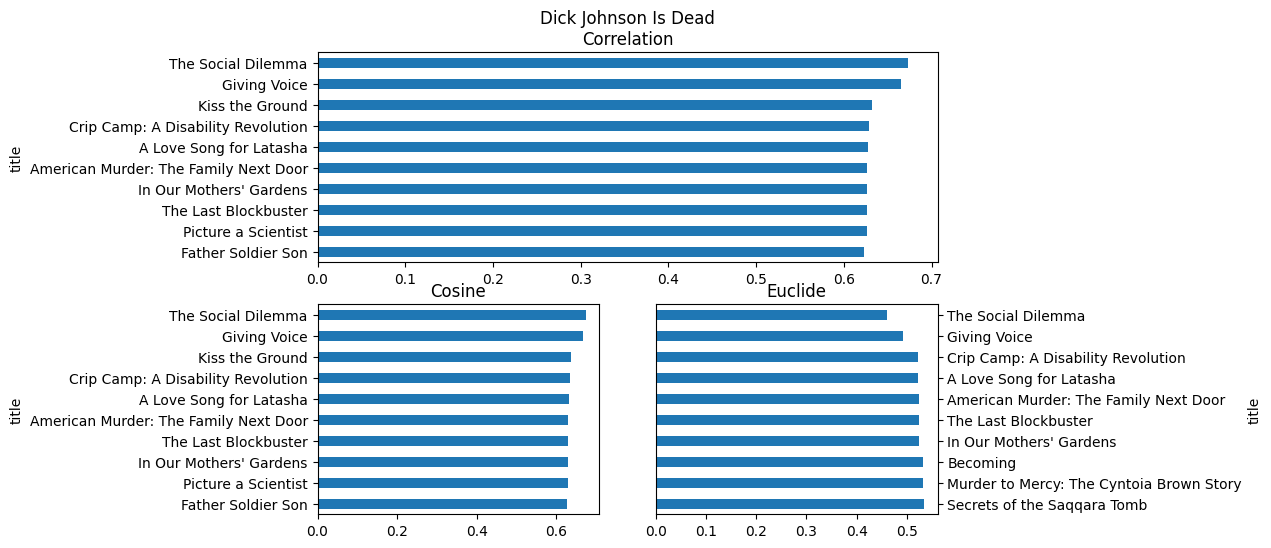

In [57]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax1, kind="barh", legend=False, title="Dick Johnson Is Dead\nCorrelation");
pd.DataFrame([model_cosine["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Dick Johnson Is Dead"].nsmallest(11)[1:]]).T.sort_values("Dick Johnson Is Dead", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [58]:
df.loc[model_corr["Dick Johnson Is Dead"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Dick Johnson Is Dead,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",As father nears end life filmmaker Kirsten Joh...,Dick Johnson Is Dead,2021,September,25
The Social Dilemma,s2036,Movie,The Social Dilemma,Jeff Orlowski,"Skyler Gisondo, Kara Hayward, Vincent Kartheiser",United States,"September 9, 2020",2020,PG-13,94 min,Documentaries,This documentary-drama hybrid explores the dan...,This documentarydrama hybrid explores dangerou...,The Social Dilemma,2020,September,9
Giving Voice,s1559,Movie,Giving Voice,"James D. Stern, Fernando Villena","Viola Davis, Denzel Washington, Stephen Hender...",United States,"December 11, 2020",2020,PG-13,91 min,Documentaries,Six ambitious student actors audition for the ...,Six ambitious student actors audition prestigi...,Giving Voice,2020,December,11
Kiss the Ground,s1961,Movie,Kiss the Ground,"Joshua Tickell, Rebecca Harrell Tickell",Woody Harrelson,United States,"September 22, 2020",2020,TV-G,85 min,Documentaries,Science experts and celebrity activists unpack...,Science experts celebrity activists unpack way...,Kiss Ground,2020,September,22
Crip Camp: A Disability Revolution,s2780,Movie,Crip Camp: A Disability Revolution,NaN,NaN,United States,"March 25, 2020",2020,R,108 min,Documentaries,A groundbreaking summer camp galvanizes a grou...,A groundbreaking summer camp galvanizes group ...,Crip Camp A Disability Revolution,2020,March,25
A Love Song for Latasha,s1963,Movie,A Love Song for Latasha,Sophia Nahli Allison,NaN,United States,"September 21, 2020",2020,TV-PG,20 min,Documentaries,The killing of Latasha Harlins became a flashp...,The killing Latasha Harlins became flashpoint ...,A Love Song Latasha,2020,September,21
American Murder: The Family Next Door,s1927,Movie,American Murder: The Family Next Door,Jenny Popplewell,NaN,United States,"September 30, 2020",2020,TV-MA,84 min,Documentaries,"Using raw, firsthand footage, this documentary...",Using raw firsthand footage documentary examin...,American Murder The Family Next Door,2020,September,30
In Our Mothers' Gardens,s908,Movie,In Our Mothers' Gardens,Shantrelle P. Lewis,NaN,United States,"May 7, 2021",2020,TV-MA,85 min,Documentaries,An unplanned pregnancy upends the carefree liv...,An unplanned pregnancy upends carefree lives y...,In Our Mothers Gardens,2021,May,7
The Last Blockbuster,s1205,Movie,The Last Blockbuster,Taylor Morden,NaN,United States,"March 15, 2021",2020,TV-14,87 min,Documentaries,This nostalgic documentary reveals the real st...,This nostalgic documentary reveals real story ...,The Last Blockbuster,2021,March,15


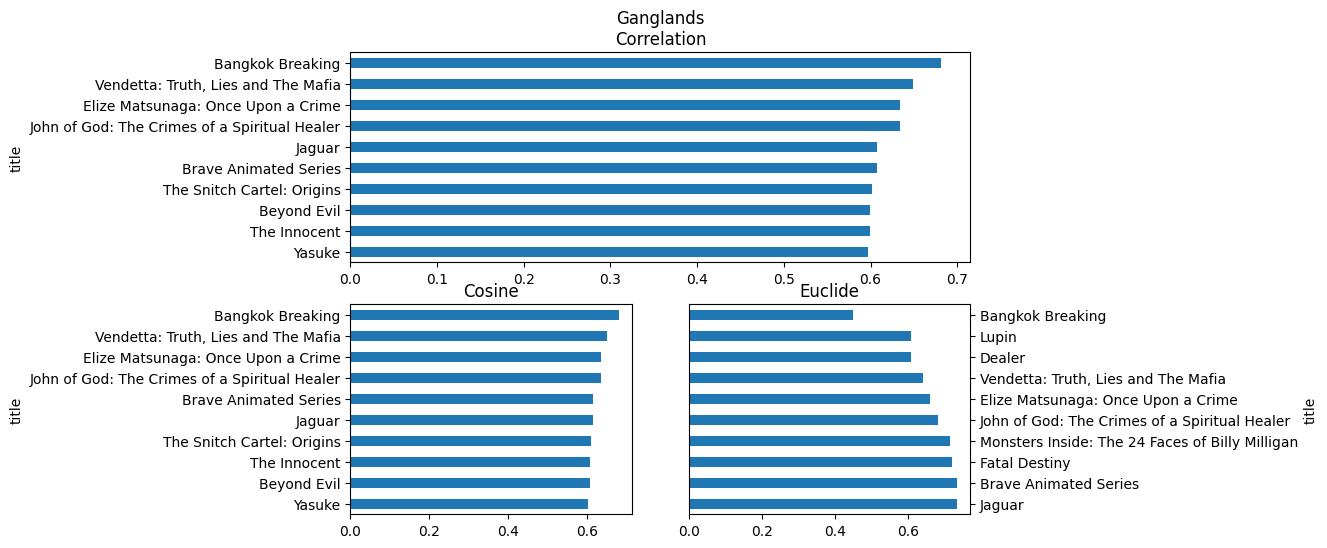

In [59]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax1, kind="barh", legend=False, title="Ganglands\nCorrelation");
pd.DataFrame([model_cosine["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Ganglands"].nsmallest(11)[1:]]).T.sort_values("Ganglands", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [60]:
df.loc[model_corr["Ganglands"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Ganglands,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,To protect family powerful drug lord skilled t...,Ganglands,2021,September,24
Bangkok Breaking,s12,TV Show,Bangkok Breaking,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",NaN,"September 23, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ...",Struggling earn living Bangkok man joins emerg...,Bangkok Breaking,2021,September,23
"Vendetta: Truth, Lies and The Mafia",s11,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows","Sicily boasts a bold ""Anti-Mafia"" coalition. B...",Sicily boasts bold AntiMafia coalition But hap...,Vendetta Truth Lies The Mafia,2021,September,24
Elize Matsunaga: Once Upon a Crime,s491,TV Show,Elize Matsunaga: Once Upon a Crime,NaN,NaN,NaN,"July 8, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",The crime shocked Brazil: Elize Matsunaga shot...,The crime shocked Brazil Elize Matsunaga shot ...,Elize Matsunaga Once Upon Crime,2021,July,8
John of God: The Crimes of a Spiritual Healer,s224,TV Show,John of God: The Crimes of a Spiritual Healer,"Mauricio Dias, Tatiana Villela",NaN,NaN,"August 25, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",Idolized medium João Teixeira de Faria rises t...,Idolized medium João Teixeira de Faria rises i...,John God The Crimes Spiritual Healer,2021,August,25
Jaguar,s20,TV Show,Jaguar,NaN,"Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...",NaN,"September 22, 2021",2021,TV-MA,1 Season,"International TV Shows, Spanish-Language TV Sh...","In the 1960s, a Holocaust survivor joins a gro...",In 1960s Holocaust survivor joins group selftr...,Jaguar,2021,September,22
Brave Animated Series,s133,TV Show,Brave Animated Series,NaN,"Tseng Yun-fan, Kao Yun-shuo, Chiang Ching-yen,...",NaN,"September 1, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Action & Adventure,...",A group of superheroes sets out to rid the wor...,A group superheroes sets rid world evil — real...,Brave Animated Series,2021,September,1
The Snitch Cartel: Origins,s382,TV Show,The Snitch Cartel: Origins,NaN,"Juan Pablo Urrego, Sebastián Osorio, Patricia ...",NaN,"July 28, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...","Over four decades, two brothers in Cali juggle...",Over four decades two brothers Cali juggle fam...,The Snitch Cartel Origins,2021,July,28
Beyond Evil,s715,TV Show,Beyond Evil,NaN,"Shin Ha-kyun, Yeo Jin-goo, Choi Dae-hoon, Choi...",NaN,"June 15, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Thr...",As a killing resembling a cold case resurfaces...,As killing resembling cold case resurfaces sma...,Beyond Evil,2021,June,15


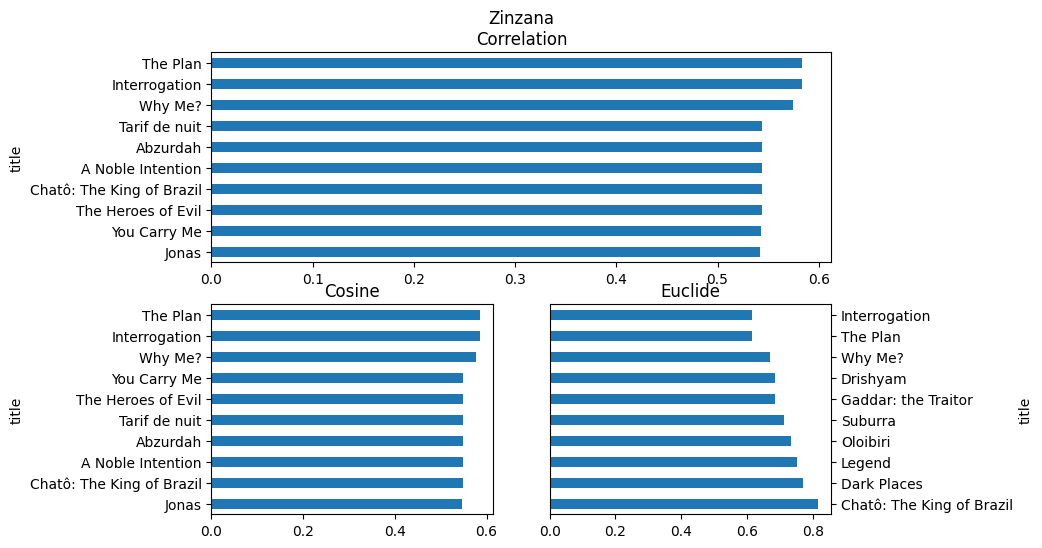

In [61]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax1, kind="barh", legend=False, title="Zinzana\nCorrelation");
pd.DataFrame([model_cosine["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zinzana"].nsmallest(11)[1:]]).T.sort_values("Zinzana", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [62]:
df.loc[model_corr["Zinzana"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zinzana,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,Recovering alcoholic Talal wakes inside smallt...,Zinzana,2016,March,9
The Plan,s8460,Movie,The Plan,Keerthi,"Anant Nag, Koustubh Jayakumar, Hemanth, Shreer...",India,"March 1, 2018",2015,TV-MA,124 min,"Dramas, International Movies, Thrillers","After being sent to a remote prison, three you...",After sent remote prison three young men suffe...,The Plan,2018,March,1
Interrogation,s5702,Movie,Interrogation,Vetrimaaran,"Dinesh Ravi, Samuthirakani, Kishore Kumar, Ana...",India,"December 1, 2016",2015,TV-MA,116 min,"Dramas, International Movies, Thrillers","In this fact-based drama, politically motivate...",In factbased drama politically motivated cops ...,Interrogation,2016,December,1
Why Me?,s3204,Movie,Why Me?,Tudor Giurgiu,"Emilian Oprea, Mihai Constantin, Andreea Vasil...","Romania, Bulgaria, Hungary","December 1, 2019",2015,TV-MA,126 min,"Dramas, International Movies, Thrillers",A young prosecutor is assigned a career-making...,A young prosecutor assigned careermaking case ...,Why Me,2019,December,1
Tarif de nuit,s8151,Movie,Tarif de nuit,Julien Seri,"Jonathan Howard, Jonathan Demurger, Fanny Vale...",France,"March 1, 2018",2015,TV-MA,81 min,"International Movies, Thrillers",A night out in Paris quickly unravels when two...,A night Paris quickly unravels two friends pro...,Tarif de nuit,2018,March,1
Abzurdah,s6083,Movie,Abzurdah,Daniela Goggi,"Eugenia Suárez, Esteban Lamothe, Gloria Carrá,...",Argentina,"August 25, 2016",2015,TV-MA,90 min,"Dramas, International Movies",A disenfranchised 16-year-old girl connects to...,A disenfranchised 16yearold girl connects olde...,Abzurdah,2016,August,25
A Noble Intention,s6051,Movie,A Noble Intention,Joram Lürsen,"Gijs Scholten van Aschat, Jacob Derwig, Rifka ...",Netherlands,"September 1, 2016",2015,TV-MA,111 min,"Dramas, International Movies","In 1888 Amsterdam, a headstrong violin maker f...",In 1888 Amsterdam headstrong violin maker find...,A Noble Intention,2016,September,1
Chatô: The King of Brazil,s5766,Movie,Chatô: The King of Brazil,Guilherme Fontes,"Marco Ricca, Andrea Beltrão, Letícia Sabatella...",Brazil,"October 1, 2016",2015,TV-MA,105 min,"Dramas, International Movies",The romanticized life of media mogul Assis Cha...,The romanticized life media mogul Assis Chatea...,Chatô The King Brazil,2016,October,1
The Heroes of Evil,s8344,Movie,The Heroes of Evil,Zoe Berriatúa,"Emilio Palacios, Jorge Clemente, Beatriz Medin...",Spain,"June 1, 2016",2015,TV-MA,99 min,"Dramas, International Movies","Three teenage misfits find camaraderie in sex,...",Three teenage misfits find camaraderie sex vio...,The Heroes Evil,2016,June,1


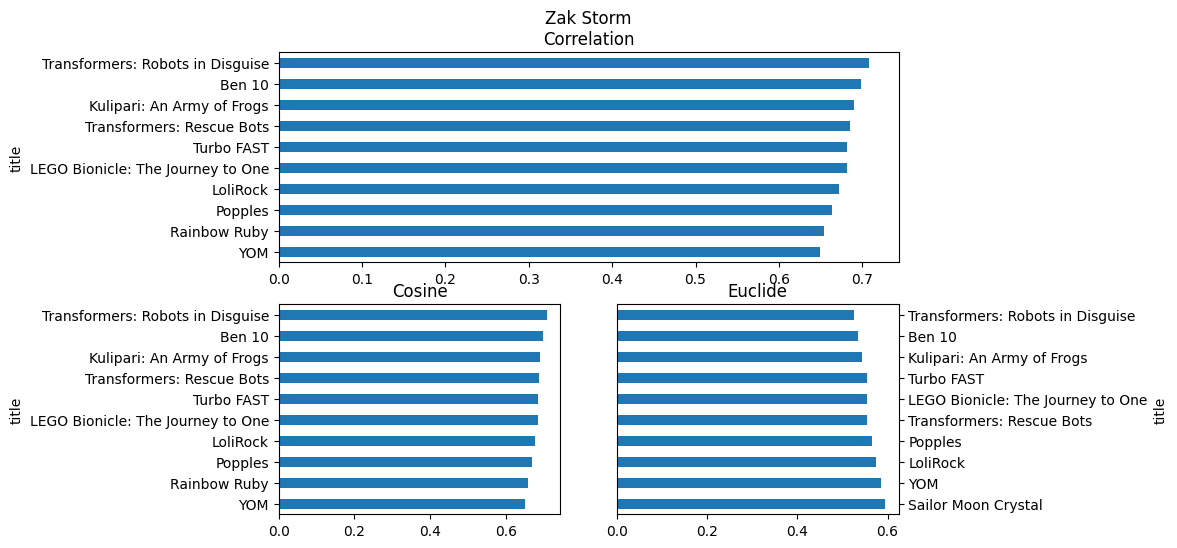

In [63]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax1, kind="barh", legend=False, title="Zak Storm\nCorrelation");
pd.DataFrame([model_cosine["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zak Storm"].nsmallest(11)[1:]]).T.sort_values("Zak Storm", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [64]:
df.loc[model_corr["Zak Storm"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zak Storm,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,Teen surfer Zak Storm mysteriously transported...,Zak Storm,2018,September,13
Transformers: Robots in Disguise,s4653,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,When prison ship crash unleashes hundreds Dece...,Transformers Robots Disguise,2018,September,8
Ben 10,s6282,TV Show,Ben 10,NaN,"Tara Strong, Montse Hernandez, David Kaye, Rog...",United States,"September 30, 2018",2016,TV-Y7,1 Season,Kids' TV,Ben can transform into ten types of aliens. He...,Ben transform ten types aliens Hell try em adv...,Ben 10,2018,September,30
Kulipari: An Army of Frogs,s5801,TV Show,Kulipari: An Army of Frogs,NaN,"Mark Hamill, Keith David, Wendie Malick, Josh ...",United States,"September 2, 2016",2016,TV-Y7,1 Season,Kids' TV,"In a tale of bravery and heroism, fearless fro...",In tale bravery heroism fearless frogs go war ...,Kulipari An Army Frogs,2016,September,2
Transformers: Rescue Bots,s4635,TV Show,Transformers: Rescue Bots,NaN,"Lacey Chabert, Elan Garfias, Maurice LaMarche,...","Canada, United States","September 19, 2018",2016,TV-Y7,1 Season,Kids' TV,Follow the adventure of four young transformer...,Follow adventure four young transformers Heatw...,Transformers Rescue Bots,2018,September,19
Turbo FAST,s5870,TV Show,Turbo FAST,NaN,"Reid Scott, John Eric Bentley, Amir Talai, Phi...",United States,"February 5, 2016",2016,TV-Y7,3 Seasons,Kids' TV,"Join Turbo and his posse, the Fast Action Stun...",Join Turbo posse Fast Action Stunt Team Filled...,Turbo FAST,2016,February,5
LEGO Bionicle: The Journey to One,s5828,TV Show,LEGO Bionicle: The Journey to One,NaN,"Nolan Balzer, Paolo Bryant, Jacqui Fox, Quinn ...",United States,"July 29, 2016",2016,TV-Y7,2 Seasons,Kids' TV,Six legendary heroes find themselves on an epi...,Six legendary heroes find epic quest harness p...,LEGO Bionicle The Journey One,2016,July,29
LoliRock,s7332,TV Show,LoliRock,NaN,"Kazumi Evans, Kelly Sheridan, Vincent Tong, As...","South Korea, France","May 1, 2018",2016,TV-Y,2 Seasons,Kids' TV,A teenager with a beautiful voice becomes a po...,A teenager beautiful voice becomes pop star di...,LoliRock,2018,May,1
Popples,s5830,TV Show,Popples,NaN,"Erin Fitzgerald, Wendee Lee, Cassandra Morris,...","United States, France","July 24, 2016",2016,TV-Y,3 Seasons,Kids' TV,The adorable Best Popple Pals love helping the...,The adorable Best Popple Pals love helping fri...,Popples,2016,July,24


In [84]:
model_corr = pd.read_csv("models/weighted models/model_2_corr.csv").set_index("title")
model_cosine = pd.read_csv("models/weighted models/model_2_cosine.csv").set_index("title")
model_euclide = pd.read_csv("models/weighted models/model_2_euclide.csv").set_index("title")

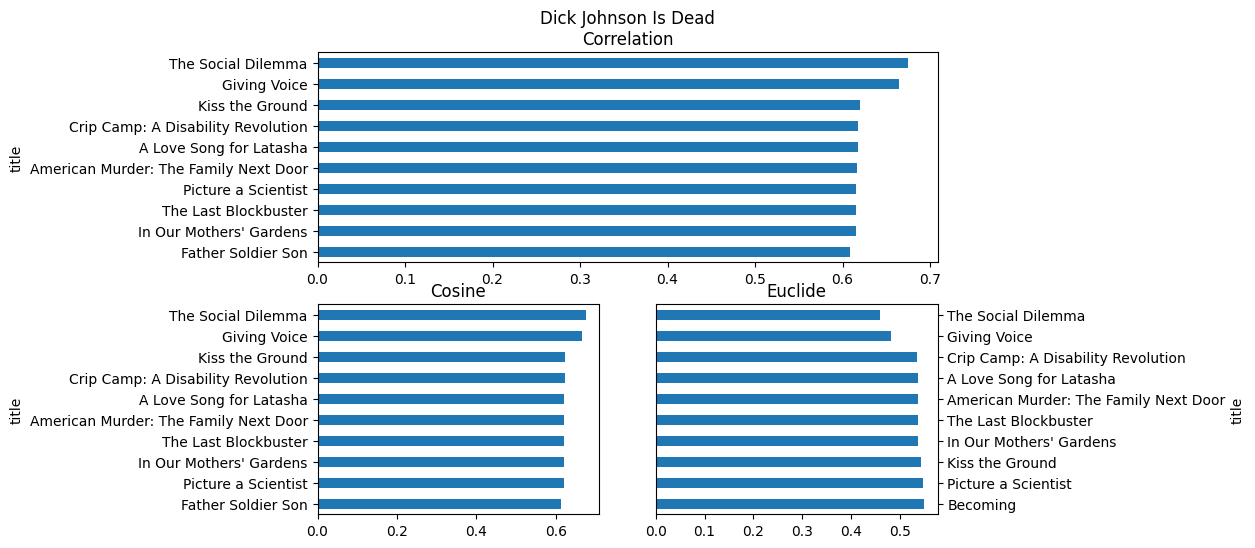

In [85]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax1, kind="barh", legend=False, title="Dick Johnson Is Dead\nCorrelation");
pd.DataFrame([model_cosine["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Dick Johnson Is Dead"].nsmallest(11)[1:]]).T.sort_values("Dick Johnson Is Dead", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [86]:
df.loc[model_corr["Dick Johnson Is Dead"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Dick Johnson Is Dead,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",As father nears end life filmmaker Kirsten Joh...,Dick Johnson Is Dead,2021,September,25
The Social Dilemma,s2036,Movie,The Social Dilemma,Jeff Orlowski,"Skyler Gisondo, Kara Hayward, Vincent Kartheiser",United States,"September 9, 2020",2020,PG-13,94 min,Documentaries,This documentary-drama hybrid explores the dan...,This documentarydrama hybrid explores dangerou...,The Social Dilemma,2020,September,9
Giving Voice,s1559,Movie,Giving Voice,"James D. Stern, Fernando Villena","Viola Davis, Denzel Washington, Stephen Hender...",United States,"December 11, 2020",2020,PG-13,91 min,Documentaries,Six ambitious student actors audition for the ...,Six ambitious student actors audition prestigi...,Giving Voice,2020,December,11
Kiss the Ground,s1961,Movie,Kiss the Ground,"Joshua Tickell, Rebecca Harrell Tickell",Woody Harrelson,United States,"September 22, 2020",2020,TV-G,85 min,Documentaries,Science experts and celebrity activists unpack...,Science experts celebrity activists unpack way...,Kiss Ground,2020,September,22
Crip Camp: A Disability Revolution,s2780,Movie,Crip Camp: A Disability Revolution,NaN,NaN,United States,"March 25, 2020",2020,R,108 min,Documentaries,A groundbreaking summer camp galvanizes a grou...,A groundbreaking summer camp galvanizes group ...,Crip Camp A Disability Revolution,2020,March,25
A Love Song for Latasha,s1963,Movie,A Love Song for Latasha,Sophia Nahli Allison,NaN,United States,"September 21, 2020",2020,TV-PG,20 min,Documentaries,The killing of Latasha Harlins became a flashp...,The killing Latasha Harlins became flashpoint ...,A Love Song Latasha,2020,September,21
American Murder: The Family Next Door,s1927,Movie,American Murder: The Family Next Door,Jenny Popplewell,NaN,United States,"September 30, 2020",2020,TV-MA,84 min,Documentaries,"Using raw, firsthand footage, this documentary...",Using raw firsthand footage documentary examin...,American Murder The Family Next Door,2020,September,30
Picture a Scientist,s728,Movie,Picture a Scientist,"Ian Cheney, Sharon Shattuck",NaN,United States,"June 13, 2021",2020,TV-MA,97 min,Documentaries,"In this documentary, leading women scientists ...",In documentary leading women scientists discus...,Picture Scientist,2021,June,13
The Last Blockbuster,s1205,Movie,The Last Blockbuster,Taylor Morden,NaN,United States,"March 15, 2021",2020,TV-14,87 min,Documentaries,This nostalgic documentary reveals the real st...,This nostalgic documentary reveals real story ...,The Last Blockbuster,2021,March,15


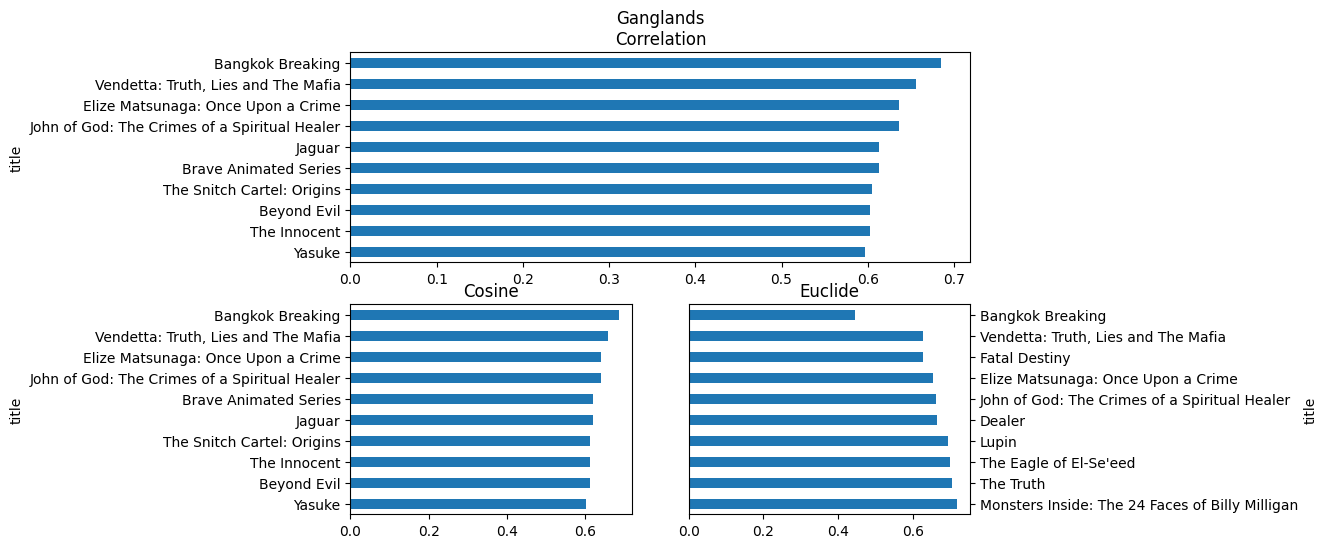

In [87]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax1, kind="barh", legend=False, title="Ganglands\nCorrelation");
pd.DataFrame([model_cosine["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Ganglands"].nsmallest(11)[1:]]).T.sort_values("Ganglands", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [88]:
df.loc[model_corr["Ganglands"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Ganglands,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,To protect family powerful drug lord skilled t...,Ganglands,2021,September,24
Bangkok Breaking,s12,TV Show,Bangkok Breaking,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",NaN,"September 23, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ...",Struggling earn living Bangkok man joins emerg...,Bangkok Breaking,2021,September,23
"Vendetta: Truth, Lies and The Mafia",s11,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows","Sicily boasts a bold ""Anti-Mafia"" coalition. B...",Sicily boasts bold AntiMafia coalition But hap...,Vendetta Truth Lies The Mafia,2021,September,24
Elize Matsunaga: Once Upon a Crime,s491,TV Show,Elize Matsunaga: Once Upon a Crime,NaN,NaN,NaN,"July 8, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",The crime shocked Brazil: Elize Matsunaga shot...,The crime shocked Brazil Elize Matsunaga shot ...,Elize Matsunaga Once Upon Crime,2021,July,8
John of God: The Crimes of a Spiritual Healer,s224,TV Show,John of God: The Crimes of a Spiritual Healer,"Mauricio Dias, Tatiana Villela",NaN,NaN,"August 25, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",Idolized medium João Teixeira de Faria rises t...,Idolized medium João Teixeira de Faria rises i...,John God The Crimes Spiritual Healer,2021,August,25
Jaguar,s20,TV Show,Jaguar,NaN,"Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...",NaN,"September 22, 2021",2021,TV-MA,1 Season,"International TV Shows, Spanish-Language TV Sh...","In the 1960s, a Holocaust survivor joins a gro...",In 1960s Holocaust survivor joins group selftr...,Jaguar,2021,September,22
Brave Animated Series,s133,TV Show,Brave Animated Series,NaN,"Tseng Yun-fan, Kao Yun-shuo, Chiang Ching-yen,...",NaN,"September 1, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Action & Adventure,...",A group of superheroes sets out to rid the wor...,A group superheroes sets rid world evil — real...,Brave Animated Series,2021,September,1
The Snitch Cartel: Origins,s382,TV Show,The Snitch Cartel: Origins,NaN,"Juan Pablo Urrego, Sebastián Osorio, Patricia ...",NaN,"July 28, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...","Over four decades, two brothers in Cali juggle...",Over four decades two brothers Cali juggle fam...,The Snitch Cartel Origins,2021,July,28
Beyond Evil,s715,TV Show,Beyond Evil,NaN,"Shin Ha-kyun, Yeo Jin-goo, Choi Dae-hoon, Choi...",NaN,"June 15, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Thr...",As a killing resembling a cold case resurfaces...,As killing resembling cold case resurfaces sma...,Beyond Evil,2021,June,15


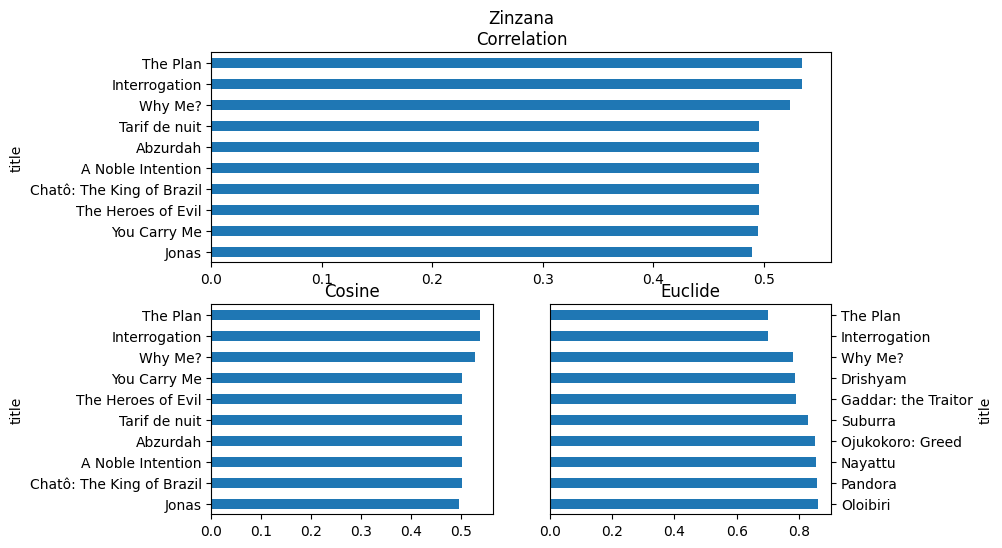

In [89]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax1, kind="barh", legend=False, title="Zinzana\nCorrelation");
pd.DataFrame([model_cosine["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zinzana"].nsmallest(11)[1:]]).T.sort_values("Zinzana", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [90]:
df.loc[model_corr["Zinzana"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zinzana,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,Recovering alcoholic Talal wakes inside smallt...,Zinzana,2016,March,9
The Plan,s8460,Movie,The Plan,Keerthi,"Anant Nag, Koustubh Jayakumar, Hemanth, Shreer...",India,"March 1, 2018",2015,TV-MA,124 min,"Dramas, International Movies, Thrillers","After being sent to a remote prison, three you...",After sent remote prison three young men suffe...,The Plan,2018,March,1
Interrogation,s5702,Movie,Interrogation,Vetrimaaran,"Dinesh Ravi, Samuthirakani, Kishore Kumar, Ana...",India,"December 1, 2016",2015,TV-MA,116 min,"Dramas, International Movies, Thrillers","In this fact-based drama, politically motivate...",In factbased drama politically motivated cops ...,Interrogation,2016,December,1
Why Me?,s3204,Movie,Why Me?,Tudor Giurgiu,"Emilian Oprea, Mihai Constantin, Andreea Vasil...","Romania, Bulgaria, Hungary","December 1, 2019",2015,TV-MA,126 min,"Dramas, International Movies, Thrillers",A young prosecutor is assigned a career-making...,A young prosecutor assigned careermaking case ...,Why Me,2019,December,1
Tarif de nuit,s8151,Movie,Tarif de nuit,Julien Seri,"Jonathan Howard, Jonathan Demurger, Fanny Vale...",France,"March 1, 2018",2015,TV-MA,81 min,"International Movies, Thrillers",A night out in Paris quickly unravels when two...,A night Paris quickly unravels two friends pro...,Tarif de nuit,2018,March,1
Abzurdah,s6083,Movie,Abzurdah,Daniela Goggi,"Eugenia Suárez, Esteban Lamothe, Gloria Carrá,...",Argentina,"August 25, 2016",2015,TV-MA,90 min,"Dramas, International Movies",A disenfranchised 16-year-old girl connects to...,A disenfranchised 16yearold girl connects olde...,Abzurdah,2016,August,25
A Noble Intention,s6051,Movie,A Noble Intention,Joram Lürsen,"Gijs Scholten van Aschat, Jacob Derwig, Rifka ...",Netherlands,"September 1, 2016",2015,TV-MA,111 min,"Dramas, International Movies","In 1888 Amsterdam, a headstrong violin maker f...",In 1888 Amsterdam headstrong violin maker find...,A Noble Intention,2016,September,1
Chatô: The King of Brazil,s5766,Movie,Chatô: The King of Brazil,Guilherme Fontes,"Marco Ricca, Andrea Beltrão, Letícia Sabatella...",Brazil,"October 1, 2016",2015,TV-MA,105 min,"Dramas, International Movies",The romanticized life of media mogul Assis Cha...,The romanticized life media mogul Assis Chatea...,Chatô The King Brazil,2016,October,1
The Heroes of Evil,s8344,Movie,The Heroes of Evil,Zoe Berriatúa,"Emilio Palacios, Jorge Clemente, Beatriz Medin...",Spain,"June 1, 2016",2015,TV-MA,99 min,"Dramas, International Movies","Three teenage misfits find camaraderie in sex,...",Three teenage misfits find camaraderie sex vio...,The Heroes Evil,2016,June,1


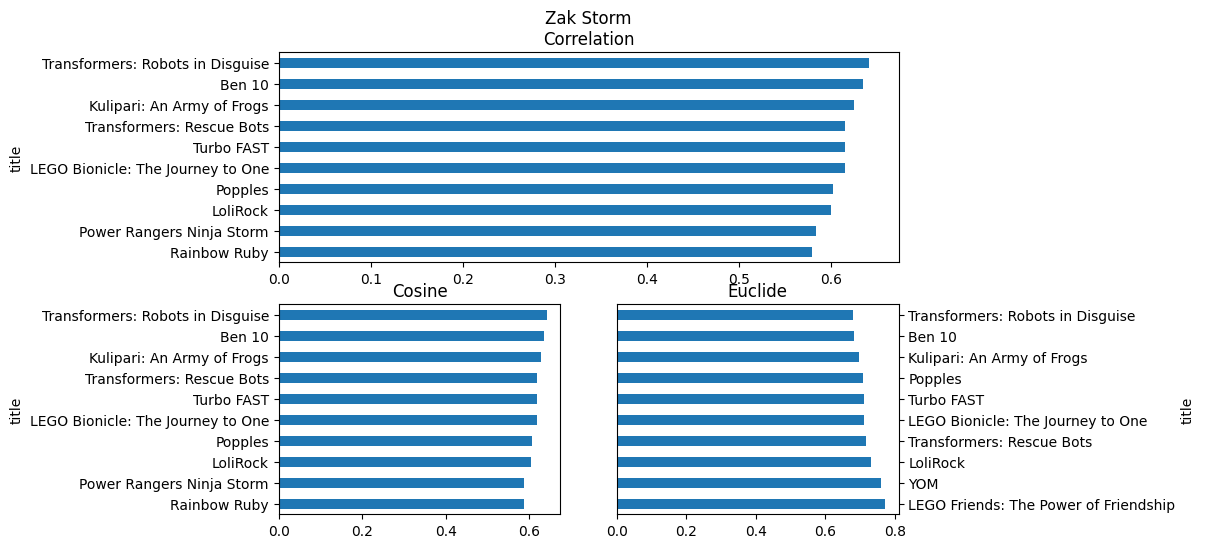

In [91]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax1, kind="barh", legend=False, title="Zak Storm\nCorrelation");
pd.DataFrame([model_cosine["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zak Storm"].nsmallest(11)[1:]]).T.sort_values("Zak Storm", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [92]:
df.loc[model_corr["Zak Storm"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zak Storm,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,Teen surfer Zak Storm mysteriously transported...,Zak Storm,2018,September,13
Transformers: Robots in Disguise,s4653,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,When prison ship crash unleashes hundreds Dece...,Transformers Robots Disguise,2018,September,8
Ben 10,s6282,TV Show,Ben 10,NaN,"Tara Strong, Montse Hernandez, David Kaye, Rog...",United States,"September 30, 2018",2016,TV-Y7,1 Season,Kids' TV,Ben can transform into ten types of aliens. He...,Ben transform ten types aliens Hell try em adv...,Ben 10,2018,September,30
Kulipari: An Army of Frogs,s5801,TV Show,Kulipari: An Army of Frogs,NaN,"Mark Hamill, Keith David, Wendie Malick, Josh ...",United States,"September 2, 2016",2016,TV-Y7,1 Season,Kids' TV,"In a tale of bravery and heroism, fearless fro...",In tale bravery heroism fearless frogs go war ...,Kulipari An Army Frogs,2016,September,2
Transformers: Rescue Bots,s4635,TV Show,Transformers: Rescue Bots,NaN,"Lacey Chabert, Elan Garfias, Maurice LaMarche,...","Canada, United States","September 19, 2018",2016,TV-Y7,1 Season,Kids' TV,Follow the adventure of four young transformer...,Follow adventure four young transformers Heatw...,Transformers Rescue Bots,2018,September,19
Turbo FAST,s5870,TV Show,Turbo FAST,NaN,"Reid Scott, John Eric Bentley, Amir Talai, Phi...",United States,"February 5, 2016",2016,TV-Y7,3 Seasons,Kids' TV,"Join Turbo and his posse, the Fast Action Stun...",Join Turbo posse Fast Action Stunt Team Filled...,Turbo FAST,2016,February,5
LEGO Bionicle: The Journey to One,s5828,TV Show,LEGO Bionicle: The Journey to One,NaN,"Nolan Balzer, Paolo Bryant, Jacqui Fox, Quinn ...",United States,"July 29, 2016",2016,TV-Y7,2 Seasons,Kids' TV,Six legendary heroes find themselves on an epi...,Six legendary heroes find epic quest harness p...,LEGO Bionicle The Journey One,2016,July,29
Popples,s5830,TV Show,Popples,NaN,"Erin Fitzgerald, Wendee Lee, Cassandra Morris,...","United States, France","July 24, 2016",2016,TV-Y,3 Seasons,Kids' TV,The adorable Best Popple Pals love helping the...,The adorable Best Popple Pals love helping fri...,Popples,2016,July,24
LoliRock,s7332,TV Show,LoliRock,NaN,"Kazumi Evans, Kelly Sheridan, Vincent Tong, As...","South Korea, France","May 1, 2018",2016,TV-Y,2 Seasons,Kids' TV,A teenager with a beautiful voice becomes a po...,A teenager beautiful voice becomes pop star di...,LoliRock,2018,May,1


In [93]:
model_corr = pd.read_csv("models/weighted models/model_3_corr.csv").set_index("title")
model_cosine = pd.read_csv("models/weighted models/model_3_cosine.csv").set_index("title")
model_euclide = pd.read_csv("models/weighted models/model_3_euclide.csv").set_index("title")

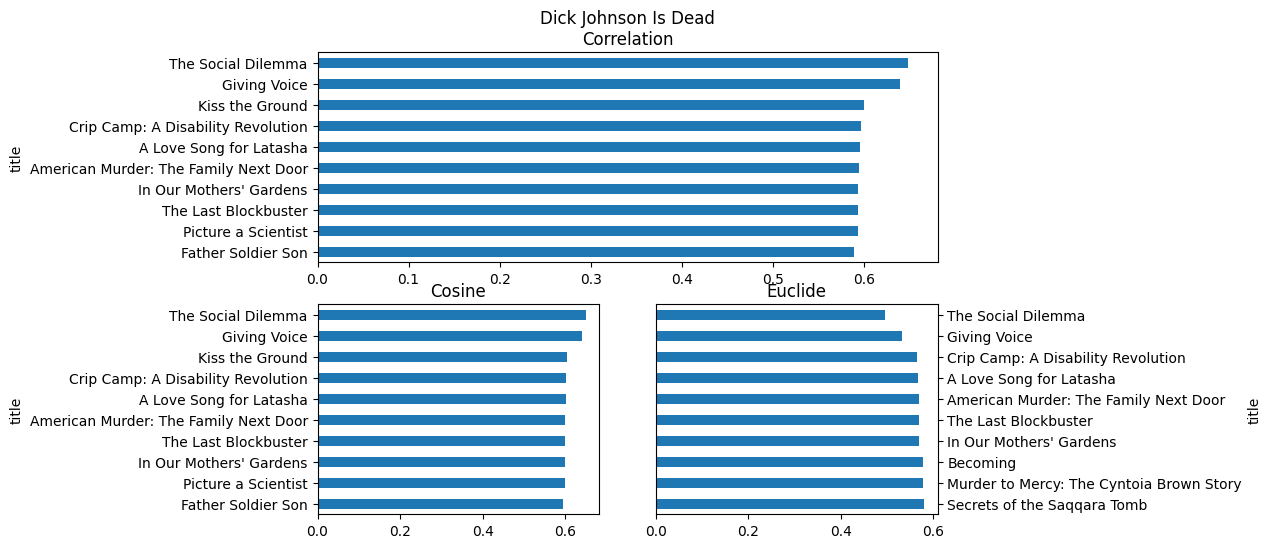

In [94]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax1, kind="barh", legend=False, title="Dick Johnson Is Dead\nCorrelation");
pd.DataFrame([model_cosine["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Dick Johnson Is Dead"].nsmallest(11)[1:]]).T.sort_values("Dick Johnson Is Dead", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [95]:
df.loc[model_corr["Dick Johnson Is Dead"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Dick Johnson Is Dead,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",As father nears end life filmmaker Kirsten Joh...,Dick Johnson Is Dead,2021,September,25
The Social Dilemma,s2036,Movie,The Social Dilemma,Jeff Orlowski,"Skyler Gisondo, Kara Hayward, Vincent Kartheiser",United States,"September 9, 2020",2020,PG-13,94 min,Documentaries,This documentary-drama hybrid explores the dan...,This documentarydrama hybrid explores dangerou...,The Social Dilemma,2020,September,9
Giving Voice,s1559,Movie,Giving Voice,"James D. Stern, Fernando Villena","Viola Davis, Denzel Washington, Stephen Hender...",United States,"December 11, 2020",2020,PG-13,91 min,Documentaries,Six ambitious student actors audition for the ...,Six ambitious student actors audition prestigi...,Giving Voice,2020,December,11
Kiss the Ground,s1961,Movie,Kiss the Ground,"Joshua Tickell, Rebecca Harrell Tickell",Woody Harrelson,United States,"September 22, 2020",2020,TV-G,85 min,Documentaries,Science experts and celebrity activists unpack...,Science experts celebrity activists unpack way...,Kiss Ground,2020,September,22
Crip Camp: A Disability Revolution,s2780,Movie,Crip Camp: A Disability Revolution,NaN,NaN,United States,"March 25, 2020",2020,R,108 min,Documentaries,A groundbreaking summer camp galvanizes a grou...,A groundbreaking summer camp galvanizes group ...,Crip Camp A Disability Revolution,2020,March,25
A Love Song for Latasha,s1963,Movie,A Love Song for Latasha,Sophia Nahli Allison,NaN,United States,"September 21, 2020",2020,TV-PG,20 min,Documentaries,The killing of Latasha Harlins became a flashp...,The killing Latasha Harlins became flashpoint ...,A Love Song Latasha,2020,September,21
American Murder: The Family Next Door,s1927,Movie,American Murder: The Family Next Door,Jenny Popplewell,NaN,United States,"September 30, 2020",2020,TV-MA,84 min,Documentaries,"Using raw, firsthand footage, this documentary...",Using raw firsthand footage documentary examin...,American Murder The Family Next Door,2020,September,30
In Our Mothers' Gardens,s908,Movie,In Our Mothers' Gardens,Shantrelle P. Lewis,NaN,United States,"May 7, 2021",2020,TV-MA,85 min,Documentaries,An unplanned pregnancy upends the carefree liv...,An unplanned pregnancy upends carefree lives y...,In Our Mothers Gardens,2021,May,7
The Last Blockbuster,s1205,Movie,The Last Blockbuster,Taylor Morden,NaN,United States,"March 15, 2021",2020,TV-14,87 min,Documentaries,This nostalgic documentary reveals the real st...,This nostalgic documentary reveals real story ...,The Last Blockbuster,2021,March,15


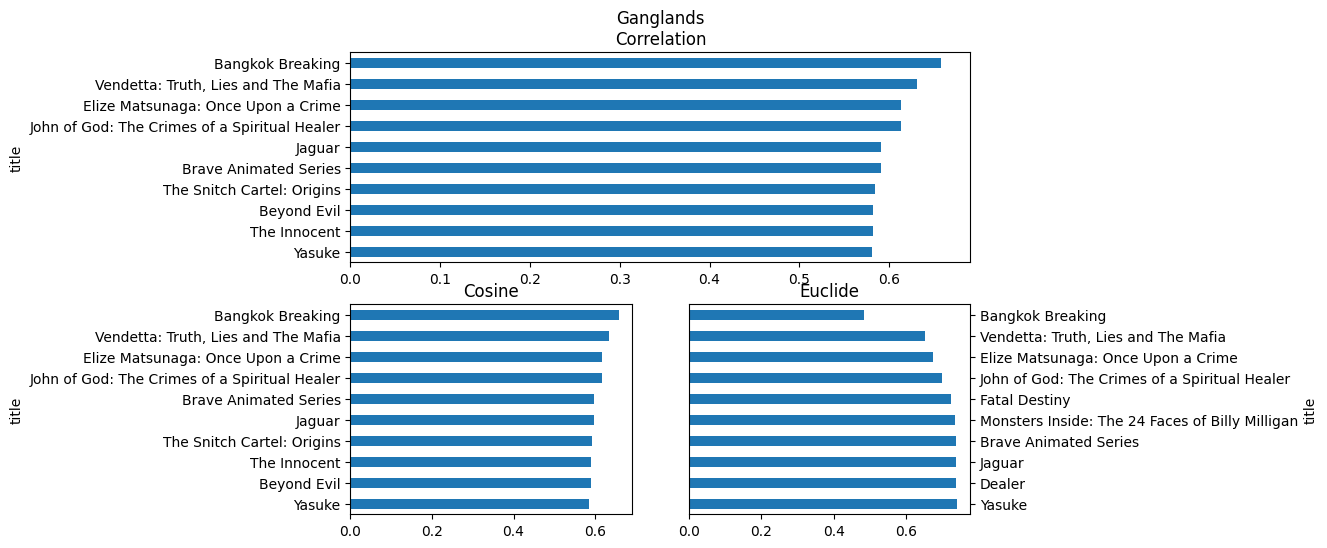

In [96]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax1, kind="barh", legend=False, title="Ganglands\nCorrelation");
pd.DataFrame([model_cosine["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Ganglands"].nsmallest(11)[1:]]).T.sort_values("Ganglands", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [97]:
df.loc[model_corr["Ganglands"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Ganglands,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,To protect family powerful drug lord skilled t...,Ganglands,2021,September,24
Bangkok Breaking,s12,TV Show,Bangkok Breaking,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",NaN,"September 23, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ...",Struggling earn living Bangkok man joins emerg...,Bangkok Breaking,2021,September,23
"Vendetta: Truth, Lies and The Mafia",s11,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows","Sicily boasts a bold ""Anti-Mafia"" coalition. B...",Sicily boasts bold AntiMafia coalition But hap...,Vendetta Truth Lies The Mafia,2021,September,24
Elize Matsunaga: Once Upon a Crime,s491,TV Show,Elize Matsunaga: Once Upon a Crime,NaN,NaN,NaN,"July 8, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",The crime shocked Brazil: Elize Matsunaga shot...,The crime shocked Brazil Elize Matsunaga shot ...,Elize Matsunaga Once Upon Crime,2021,July,8
John of God: The Crimes of a Spiritual Healer,s224,TV Show,John of God: The Crimes of a Spiritual Healer,"Mauricio Dias, Tatiana Villela",NaN,NaN,"August 25, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows",Idolized medium João Teixeira de Faria rises t...,Idolized medium João Teixeira de Faria rises i...,John God The Crimes Spiritual Healer,2021,August,25
Jaguar,s20,TV Show,Jaguar,NaN,"Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...",NaN,"September 22, 2021",2021,TV-MA,1 Season,"International TV Shows, Spanish-Language TV Sh...","In the 1960s, a Holocaust survivor joins a gro...",In 1960s Holocaust survivor joins group selftr...,Jaguar,2021,September,22
Brave Animated Series,s133,TV Show,Brave Animated Series,NaN,"Tseng Yun-fan, Kao Yun-shuo, Chiang Ching-yen,...",NaN,"September 1, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Action & Adventure,...",A group of superheroes sets out to rid the wor...,A group superheroes sets rid world evil — real...,Brave Animated Series,2021,September,1
The Snitch Cartel: Origins,s382,TV Show,The Snitch Cartel: Origins,NaN,"Juan Pablo Urrego, Sebastián Osorio, Patricia ...",NaN,"July 28, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...","Over four decades, two brothers in Cali juggle...",Over four decades two brothers Cali juggle fam...,The Snitch Cartel Origins,2021,July,28
Beyond Evil,s715,TV Show,Beyond Evil,NaN,"Shin Ha-kyun, Yeo Jin-goo, Choi Dae-hoon, Choi...",NaN,"June 15, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Thr...",As a killing resembling a cold case resurfaces...,As killing resembling cold case resurfaces sma...,Beyond Evil,2021,June,15


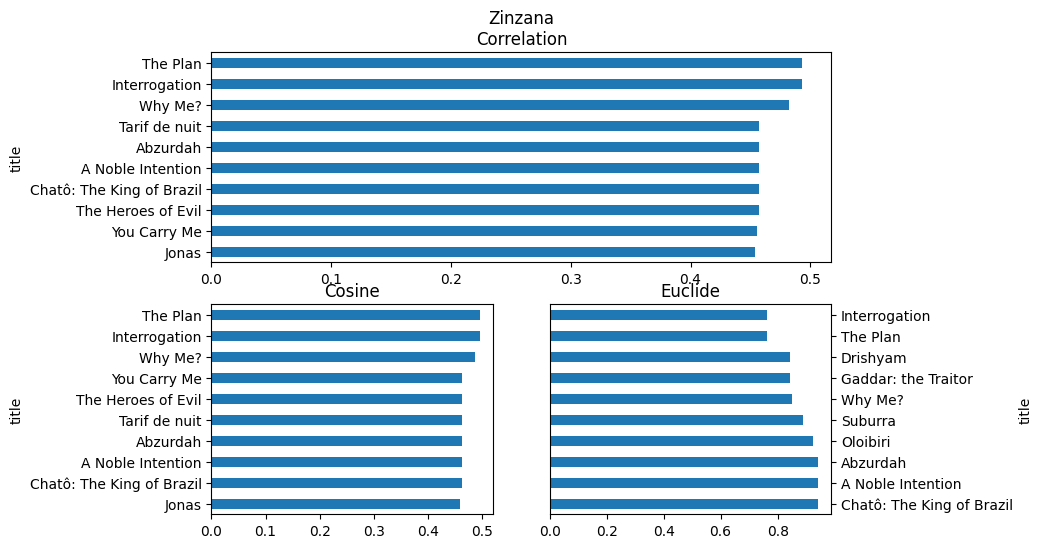

In [98]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax1, kind="barh", legend=False, title="Zinzana\nCorrelation");
pd.DataFrame([model_cosine["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zinzana"].nsmallest(11)[1:]]).T.sort_values("Zinzana", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [99]:
df.loc[model_corr["Zinzana"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zinzana,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,Recovering alcoholic Talal wakes inside smallt...,Zinzana,2016,March,9
The Plan,s8460,Movie,The Plan,Keerthi,"Anant Nag, Koustubh Jayakumar, Hemanth, Shreer...",India,"March 1, 2018",2015,TV-MA,124 min,"Dramas, International Movies, Thrillers","After being sent to a remote prison, three you...",After sent remote prison three young men suffe...,The Plan,2018,March,1
Interrogation,s5702,Movie,Interrogation,Vetrimaaran,"Dinesh Ravi, Samuthirakani, Kishore Kumar, Ana...",India,"December 1, 2016",2015,TV-MA,116 min,"Dramas, International Movies, Thrillers","In this fact-based drama, politically motivate...",In factbased drama politically motivated cops ...,Interrogation,2016,December,1
Why Me?,s3204,Movie,Why Me?,Tudor Giurgiu,"Emilian Oprea, Mihai Constantin, Andreea Vasil...","Romania, Bulgaria, Hungary","December 1, 2019",2015,TV-MA,126 min,"Dramas, International Movies, Thrillers",A young prosecutor is assigned a career-making...,A young prosecutor assigned careermaking case ...,Why Me,2019,December,1
Tarif de nuit,s8151,Movie,Tarif de nuit,Julien Seri,"Jonathan Howard, Jonathan Demurger, Fanny Vale...",France,"March 1, 2018",2015,TV-MA,81 min,"International Movies, Thrillers",A night out in Paris quickly unravels when two...,A night Paris quickly unravels two friends pro...,Tarif de nuit,2018,March,1
Abzurdah,s6083,Movie,Abzurdah,Daniela Goggi,"Eugenia Suárez, Esteban Lamothe, Gloria Carrá,...",Argentina,"August 25, 2016",2015,TV-MA,90 min,"Dramas, International Movies",A disenfranchised 16-year-old girl connects to...,A disenfranchised 16yearold girl connects olde...,Abzurdah,2016,August,25
A Noble Intention,s6051,Movie,A Noble Intention,Joram Lürsen,"Gijs Scholten van Aschat, Jacob Derwig, Rifka ...",Netherlands,"September 1, 2016",2015,TV-MA,111 min,"Dramas, International Movies","In 1888 Amsterdam, a headstrong violin maker f...",In 1888 Amsterdam headstrong violin maker find...,A Noble Intention,2016,September,1
Chatô: The King of Brazil,s5766,Movie,Chatô: The King of Brazil,Guilherme Fontes,"Marco Ricca, Andrea Beltrão, Letícia Sabatella...",Brazil,"October 1, 2016",2015,TV-MA,105 min,"Dramas, International Movies",The romanticized life of media mogul Assis Cha...,The romanticized life media mogul Assis Chatea...,Chatô The King Brazil,2016,October,1
The Heroes of Evil,s8344,Movie,The Heroes of Evil,Zoe Berriatúa,"Emilio Palacios, Jorge Clemente, Beatriz Medin...",Spain,"June 1, 2016",2015,TV-MA,99 min,"Dramas, International Movies","Three teenage misfits find camaraderie in sex,...",Three teenage misfits find camaraderie sex vio...,The Heroes Evil,2016,June,1


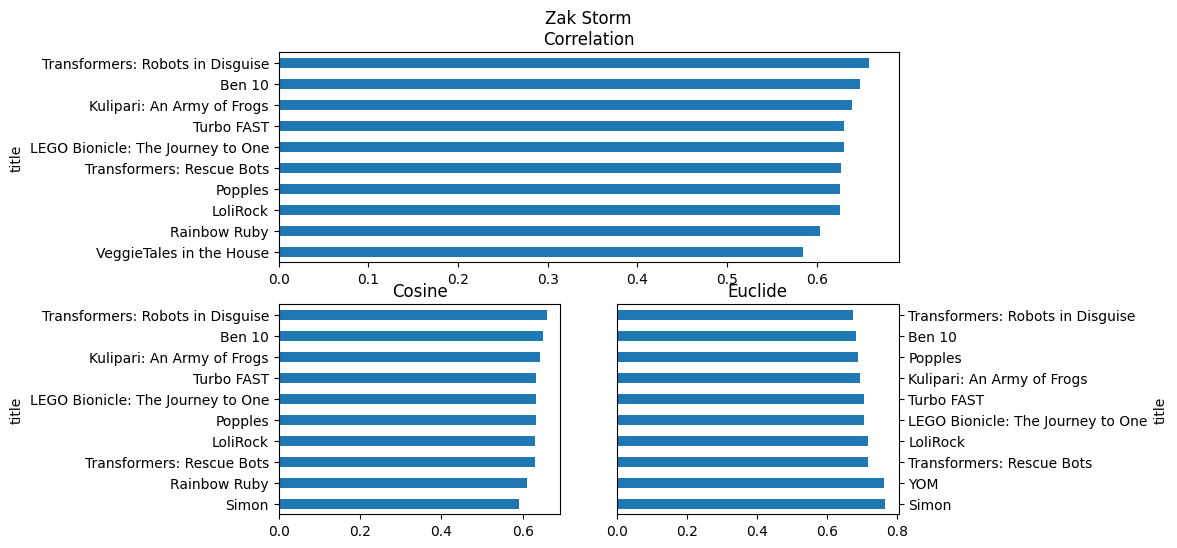

In [100]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax1, kind="barh", legend=False, title="Zak Storm\nCorrelation");
pd.DataFrame([model_cosine["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zak Storm"].nsmallest(11)[1:]]).T.sort_values("Zak Storm", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [101]:
df.loc[model_corr["Zak Storm"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zak Storm,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,Teen surfer Zak Storm mysteriously transported...,Zak Storm,2018,September,13
Transformers: Robots in Disguise,s4653,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,When prison ship crash unleashes hundreds Dece...,Transformers Robots Disguise,2018,September,8
Ben 10,s6282,TV Show,Ben 10,NaN,"Tara Strong, Montse Hernandez, David Kaye, Rog...",United States,"September 30, 2018",2016,TV-Y7,1 Season,Kids' TV,Ben can transform into ten types of aliens. He...,Ben transform ten types aliens Hell try em adv...,Ben 10,2018,September,30
Kulipari: An Army of Frogs,s5801,TV Show,Kulipari: An Army of Frogs,NaN,"Mark Hamill, Keith David, Wendie Malick, Josh ...",United States,"September 2, 2016",2016,TV-Y7,1 Season,Kids' TV,"In a tale of bravery and heroism, fearless fro...",In tale bravery heroism fearless frogs go war ...,Kulipari An Army Frogs,2016,September,2
Turbo FAST,s5870,TV Show,Turbo FAST,NaN,"Reid Scott, John Eric Bentley, Amir Talai, Phi...",United States,"February 5, 2016",2016,TV-Y7,3 Seasons,Kids' TV,"Join Turbo and his posse, the Fast Action Stun...",Join Turbo posse Fast Action Stunt Team Filled...,Turbo FAST,2016,February,5
LEGO Bionicle: The Journey to One,s5828,TV Show,LEGO Bionicle: The Journey to One,NaN,"Nolan Balzer, Paolo Bryant, Jacqui Fox, Quinn ...",United States,"July 29, 2016",2016,TV-Y7,2 Seasons,Kids' TV,Six legendary heroes find themselves on an epi...,Six legendary heroes find epic quest harness p...,LEGO Bionicle The Journey One,2016,July,29
Transformers: Rescue Bots,s4635,TV Show,Transformers: Rescue Bots,NaN,"Lacey Chabert, Elan Garfias, Maurice LaMarche,...","Canada, United States","September 19, 2018",2016,TV-Y7,1 Season,Kids' TV,Follow the adventure of four young transformer...,Follow adventure four young transformers Heatw...,Transformers Rescue Bots,2018,September,19
Popples,s5830,TV Show,Popples,NaN,"Erin Fitzgerald, Wendee Lee, Cassandra Morris,...","United States, France","July 24, 2016",2016,TV-Y,3 Seasons,Kids' TV,The adorable Best Popple Pals love helping the...,The adorable Best Popple Pals love helping fri...,Popples,2016,July,24
LoliRock,s7332,TV Show,LoliRock,NaN,"Kazumi Evans, Kelly Sheridan, Vincent Tong, As...","South Korea, France","May 1, 2018",2016,TV-Y,2 Seasons,Kids' TV,A teenager with a beautiful voice becomes a po...,A teenager beautiful voice becomes pop star di...,LoliRock,2018,May,1


In [102]:
model_corr = pd.read_csv("models/weighted models/model_4_corr.csv").set_index("title")
model_cosine = pd.read_csv("models/weighted models/model_4_cosine.csv").set_index("title")
model_euclide = pd.read_csv("models/weighted models/model_4_euclide.csv").set_index("title")

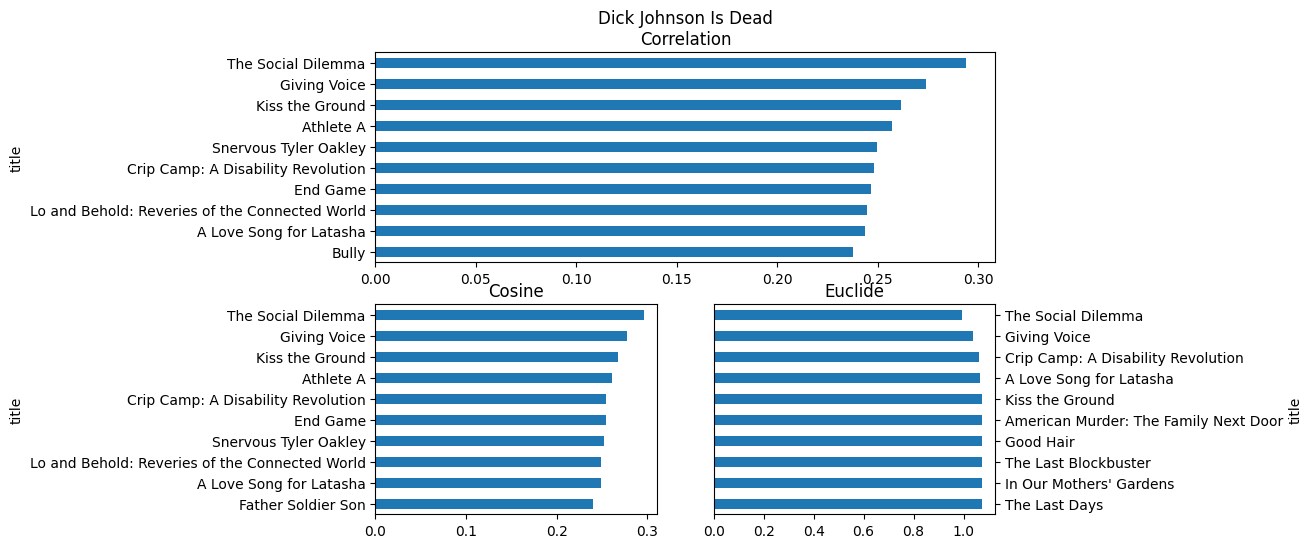

In [103]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax1, kind="barh", legend=False, title="Dick Johnson Is Dead\nCorrelation");
pd.DataFrame([model_cosine["Dick Johnson Is Dead"].nlargest(11)[1:]]).T.sort_values("Dick Johnson Is Dead").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Dick Johnson Is Dead"].nsmallest(11)[1:]]).T.sort_values("Dick Johnson Is Dead", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [104]:
df.loc[model_corr["Dick Johnson Is Dead"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Dick Johnson Is Dead,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",As father nears end life filmmaker Kirsten Joh...,Dick Johnson Is Dead,2021,September,25
The Social Dilemma,s2036,Movie,The Social Dilemma,Jeff Orlowski,"Skyler Gisondo, Kara Hayward, Vincent Kartheiser",United States,"September 9, 2020",2020,PG-13,94 min,Documentaries,This documentary-drama hybrid explores the dan...,This documentarydrama hybrid explores dangerou...,The Social Dilemma,2020,September,9
Giving Voice,s1559,Movie,Giving Voice,"James D. Stern, Fernando Villena","Viola Davis, Denzel Washington, Stephen Hender...",United States,"December 11, 2020",2020,PG-13,91 min,Documentaries,Six ambitious student actors audition for the ...,Six ambitious student actors audition prestigi...,Giving Voice,2020,December,11
Kiss the Ground,s1961,Movie,Kiss the Ground,"Joshua Tickell, Rebecca Harrell Tickell",Woody Harrelson,United States,"September 22, 2020",2020,TV-G,85 min,Documentaries,Science experts and celebrity activists unpack...,Science experts celebrity activists unpack way...,Kiss Ground,2020,September,22
Athlete A,s2342,Movie,Athlete A,"Bonni Cohen, Jon Shenk",NaN,United States,"June 24, 2020",2020,PG-13,104 min,"Documentaries, Sports Movies",This documentary focuses on the gymnasts who s...,This documentary focuses gymnasts survived USA...,Athlete A,2020,June,24
Snervous Tyler Oakley,s174,Movie,Snervous Tyler Oakley,Amy Rice,Tyler Oakley,United States,"September 1, 2021",2015,PG-13,83 min,"Documentaries, LGBTQ Movies",The inspiring Internet star and LGBT advocate ...,The inspiring Internet star LGBT advocate shar...,Snervous Tyler Oakley,2021,September,1
Crip Camp: A Disability Revolution,s2780,Movie,Crip Camp: A Disability Revolution,NaN,NaN,United States,"March 25, 2020",2020,R,108 min,Documentaries,A groundbreaking summer camp galvanizes a grou...,A groundbreaking summer camp galvanizes group ...,Crip Camp A Disability Revolution,2020,March,25
End Game,s4878,Movie,End Game,"Rob Epstein, Jeffrey Friedman",NaN,United States,"May 4, 2018",2018,TV-PG,40 min,Documentaries,"Facing an inevitable outcome, terminally ill p...",Facing inevitable outcome terminally ill patie...,End Game,2018,May,4
Lo and Behold: Reveries of the Connected World,s7324,Movie,Lo and Behold: Reveries of the Connected World,Werner Herzog,Werner Herzog,United States,"December 23, 2016",2016,PG-13,98 min,Documentaries,Filmmaker Werner Herzog presents a history of ...,Filmmaker Werner Herzog presents history inter...,Lo Behold Reveries Connected World,2016,December,23


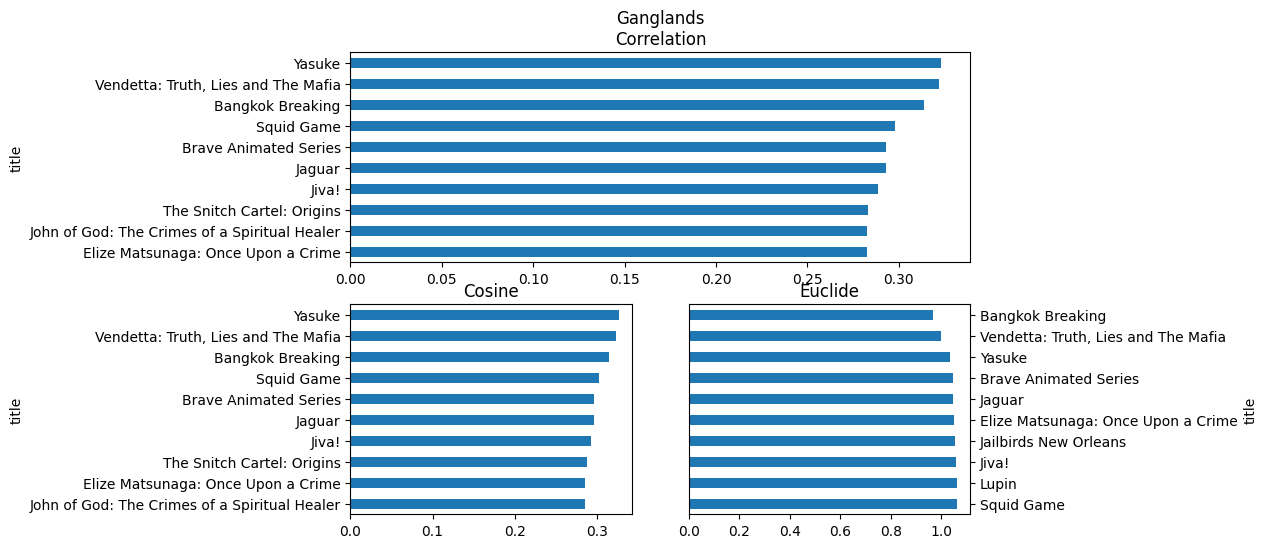

In [105]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax1, kind="barh", legend=False, title="Ganglands\nCorrelation");
pd.DataFrame([model_cosine["Ganglands"].nlargest(11)[1:]]).T.sort_values("Ganglands").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Ganglands"].nsmallest(11)[1:]]).T.sort_values("Ganglands", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [106]:
df.loc[model_corr["Ganglands"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Ganglands,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,To protect family powerful drug lord skilled t...,Ganglands,2021,September,24
Yasuke,s966,TV Show,Yasuke,NaN,"LaKeith Stanfield, Takehiro Hira, Maya Tanida,...",NaN,"April 29, 2021",2021,TV-MA,1 Season,International TV Shows,A peaceful boatman once known as the Black Sam...,A peaceful boatman known Black Samurai pulled ...,Yasuke,2021,April,29
"Vendetta: Truth, Lies and The Mafia",s11,TV Show,"Vendetta: Truth, Lies and The Mafia",NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows","Sicily boasts a bold ""Anti-Mafia"" coalition. B...",Sicily boasts bold AntiMafia coalition But hap...,Vendetta Truth Lies The Mafia,2021,September,24
Bangkok Breaking,s12,TV Show,Bangkok Breaking,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",NaN,"September 23, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ...",Struggling earn living Bangkok man joins emerg...,Bangkok Breaking,2021,September,23
Squid Game,s34,TV Show,Squid Game,NaN,"Lee Jung-jae, Park Hae-soo, Wi Ha-jun, Oh Youn...",NaN,"September 17, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Thrillers",Hundreds of cash-strapped players accept a str...,Hundreds cashstrapped players accept strange i...,Squid Game,2021,September,17
Brave Animated Series,s133,TV Show,Brave Animated Series,NaN,"Tseng Yun-fan, Kao Yun-shuo, Chiang Ching-yen,...",NaN,"September 1, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Action & Adventure,...",A group of superheroes sets out to rid the wor...,A group superheroes sets rid world evil — real...,Brave Animated Series,2021,September,1
Jaguar,s20,TV Show,Jaguar,NaN,"Blanca Suárez, Iván Marcos, Óscar Casas, Adriá...",NaN,"September 22, 2021",2021,TV-MA,1 Season,"International TV Shows, Spanish-Language TV Sh...","In the 1960s, a Holocaust survivor joins a gro...",In 1960s Holocaust survivor joins group selftr...,Jaguar,2021,September,22
Jiva!,s641,TV Show,Jiva!,NaN,"Noxolo Dlamini, Candice Modiselle, Sne Mbatha,...",NaN,"June 24, 2021",2021,TV-MA,1 Season,"International TV Shows, TV Dramas","A talented street dancer from Umlazi, Durban m...",A talented street dancer Umlazi Durban must co...,Jiva,2021,June,24
The Snitch Cartel: Origins,s382,TV Show,The Snitch Cartel: Origins,NaN,"Juan Pablo Urrego, Sebastián Osorio, Patricia ...",NaN,"July 28, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...","Over four decades, two brothers in Cali juggle...",Over four decades two brothers Cali juggle fam...,The Snitch Cartel Origins,2021,July,28


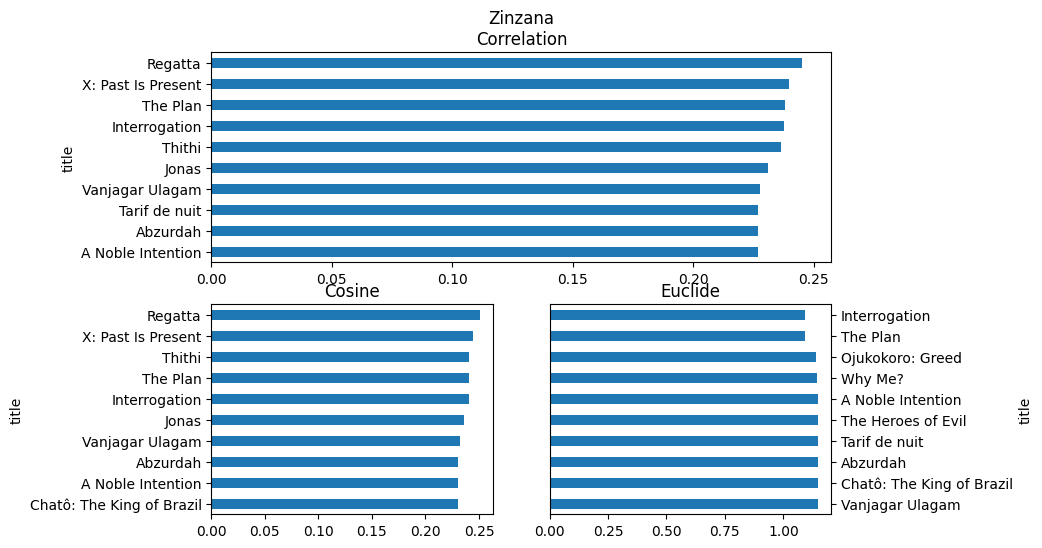

In [107]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax1, kind="barh", legend=False, title="Zinzana\nCorrelation");
pd.DataFrame([model_cosine["Zinzana"].nlargest(11)[1:]]).T.sort_values("Zinzana").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zinzana"].nsmallest(11)[1:]]).T.sort_values("Zinzana", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [108]:
df.loc[model_corr["Zinzana"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zinzana,s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...,Recovering alcoholic Talal wakes inside smallt...,Zinzana,2016,March,9
Regatta,s7850,Movie,Regatta,Mohamed Samy,"Amr Saad, Ilham Shaheen, Rania Yousef",Egypt,"May 9, 2019",2015,TV-MA,100 min,"Action & Adventure, Dramas, International Movies",Inside one of Cairo's most impoverished areas ...,Inside one Cairos impoverished areas exists pl...,Regatta,2019,May,9
X: Past Is Present,s5838,Movie,X: Past Is Present,"Hemant Gaba, Pratim D. Gupta, Sudhish Kamath, ...","Anshuman Jha, Rajat Kapoor, Pooja Ruparel, Pia...",India,"July 1, 2016",2015,TV-MA,105 min,"Dramas, Independent Movies, International Movies",When a middle-aged filmmaker meets an alluring...,When middleaged filmmaker meets alluring stran...,X Past Is Present,2016,July,1
The Plan,s8460,Movie,The Plan,Keerthi,"Anant Nag, Koustubh Jayakumar, Hemanth, Shreer...",India,"March 1, 2018",2015,TV-MA,124 min,"Dramas, International Movies, Thrillers","After being sent to a remote prison, three you...",After sent remote prison three young men suffe...,The Plan,2018,March,1
Interrogation,s5702,Movie,Interrogation,Vetrimaaran,"Dinesh Ravi, Samuthirakani, Kishore Kumar, Ana...",India,"December 1, 2016",2015,TV-MA,116 min,"Dramas, International Movies, Thrillers","In this fact-based drama, politically motivate...",In factbased drama politically motivated cops ...,Interrogation,2016,December,1
Thithi,s8579,Movie,Thithi,Raam Reddy,"Thammegowda S., Channegowda, Abhishek H.N., Po...","India, United States","March 9, 2017",2015,TV-MA,123 min,"Dramas, Independent Movies, International Movies","In a South Indian village, a centenarian's fun...",In South Indian village centenarians funeral b...,Thithi,2017,March,9
Jonas,s5589,Movie,Jonas,Lô Politi,"Jesuíta Barbosa, Laura Neiva, Criolo, Ana Cecí...",Brazil,"February 26, 2017",2015,TV-MA,97 min,"Dramas, International Movies","During Carnival, two teens from different clas...",During Carnival two teens different classes me...,Jonas,2017,February,26
Vanjagar Ulagam,s4304,Movie,Vanjagar Ulagam,Manoj Beedha,"Guru Somasundaram, Cibi Bhuvana Chandran, Vish...",India,"December 15, 2018",2018,TV-MA,145 min,"Dramas, International Movies, Thrillers",Shyam wakes to discover he's suspected in a mu...,Shyam wakes discover hes suspected murder one ...,Vanjagar Ulagam,2018,December,15
Tarif de nuit,s8151,Movie,Tarif de nuit,Julien Seri,"Jonathan Howard, Jonathan Demurger, Fanny Vale...",France,"March 1, 2018",2015,TV-MA,81 min,"International Movies, Thrillers",A night out in Paris quickly unravels when two...,A night Paris quickly unravels two friends pro...,Tarif de nuit,2018,March,1


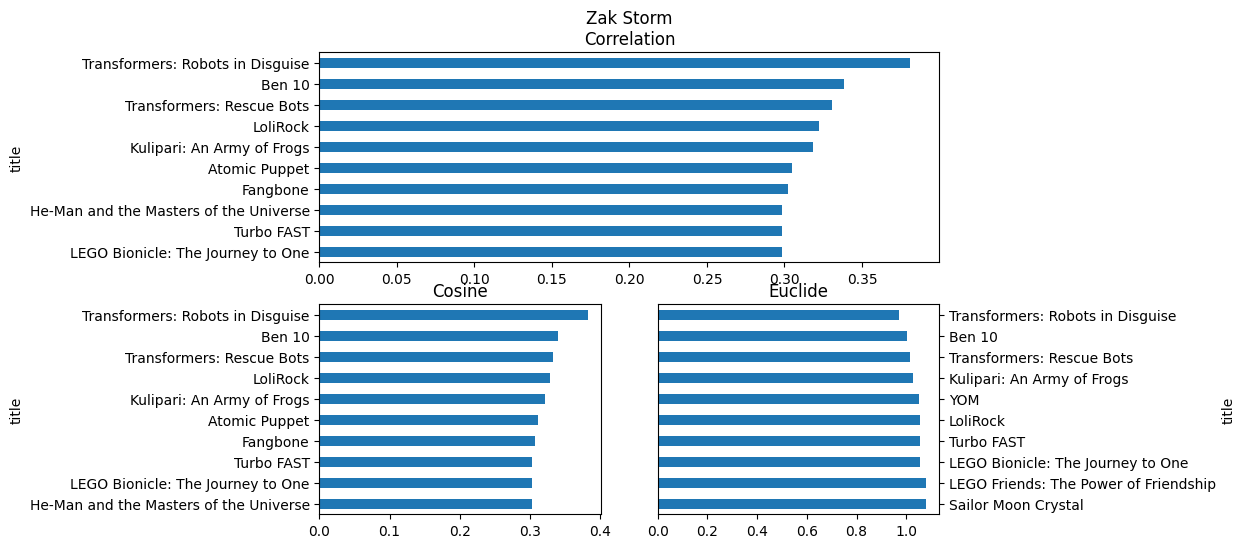

In [109]:
fig = plt.figure(figsize=(8,6))
gs = mpl.gridspec.GridSpec(2,2, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

pd.DataFrame([model_corr["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax1, kind="barh", legend=False, title="Zak Storm\nCorrelation");
pd.DataFrame([model_cosine["Zak Storm"].nlargest(11)[1:]]).T.sort_values("Zak Storm").plot(ax=ax2, kind="barh", legend=False, title="Cosine");
pd.DataFrame([model_euclide["Zak Storm"].nsmallest(11)[1:]]).T.sort_values("Zak Storm", ascending=False).plot(ax=ax3, kind="barh", legend=False, title="Euclide");
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

In [110]:
df.loc[model_corr["Zak Storm"].nlargest(11).index]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,desc_no_stopwords,title_no_stopwords,year_added,month_added,day_added
title,,,,,,,,,,,,,,,,,
Zak Storm,s8798,TV Show,Zak Storm,NaN,"Michael Johnston, Jessica Gee-George, Christin...","United States, France, South Korea, Indonesia","September 13, 2018",2016,TV-Y7,3 Seasons,Kids' TV,Teen surfer Zak Storm is mysteriously transpor...,Teen surfer Zak Storm mysteriously transported...,Zak Storm,2018,September,13
Transformers: Robots in Disguise,s4653,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,When prison ship crash unleashes hundreds Dece...,Transformers Robots Disguise,2018,September,8
Ben 10,s6282,TV Show,Ben 10,NaN,"Tara Strong, Montse Hernandez, David Kaye, Rog...",United States,"September 30, 2018",2016,TV-Y7,1 Season,Kids' TV,Ben can transform into ten types of aliens. He...,Ben transform ten types aliens Hell try em adv...,Ben 10,2018,September,30
Transformers: Rescue Bots,s4635,TV Show,Transformers: Rescue Bots,NaN,"Lacey Chabert, Elan Garfias, Maurice LaMarche,...","Canada, United States","September 19, 2018",2016,TV-Y7,1 Season,Kids' TV,Follow the adventure of four young transformer...,Follow adventure four young transformers Heatw...,Transformers Rescue Bots,2018,September,19
LoliRock,s7332,TV Show,LoliRock,NaN,"Kazumi Evans, Kelly Sheridan, Vincent Tong, As...","South Korea, France","May 1, 2018",2016,TV-Y,2 Seasons,Kids' TV,A teenager with a beautiful voice becomes a po...,A teenager beautiful voice becomes pop star di...,LoliRock,2018,May,1
Kulipari: An Army of Frogs,s5801,TV Show,Kulipari: An Army of Frogs,NaN,"Mark Hamill, Keith David, Wendie Malick, Josh ...",United States,"September 2, 2016",2016,TV-Y7,1 Season,Kids' TV,"In a tale of bravery and heroism, fearless fro...",In tale bravery heroism fearless frogs go war ...,Kulipari An Army Frogs,2016,September,2
Atomic Puppet,s6195,TV Show,Atomic Puppet,NaN,"Eric Bauza, Lisa Norton, Carlos Díaz, Peter Ol...","Canada, France","December 1, 2017",2016,TV-Y7,1 Season,"Crime TV Shows, Kids' TV, TV Comedies","Captain Atomic – once a superhero, now a sock ...",Captain Atomic – superhero sock puppet – activ...,Atomic Puppet,2017,December,1
Fangbone,s5520,TV Show,Fangbone,NaN,"Taylor Abrahamse, Colin Doyle, Juan Chioran, K...",Canada,"April 22, 2017",2016,TV-Y7,1 Season,"Kids' TV, TV Comedies","Magically transported from far-off Skullbania,...",Magically transported faroff Skullbania young ...,Fangbone,2017,April,22
He-Man and the Masters of the Universe,s41,TV Show,He-Man and the Masters of the Universe,NaN,"Yuri Lowenthal, Kimberly Brooks, Antony Del Ri...",United States,"September 16, 2021",2021,TV-Y7,1 Season,"Kids' TV, TV Sci-Fi & Fantasy",Mighty teen Adam and his heroic squad of misfi...,Mighty teen Adam heroic squad misfits discover...,HeMan Masters Universe,2021,September,16


# All 3 models give mostly the same answer even though Pearson Correlation does it slightly better with more distinction between different objects and Euclidian distance sometimes don't give accurate information

Accuracy aside there is a big flaw with Pearson Correlation that the other 2 don't have. It is the most memory and computation heavy. When Euclidian distance and cosine similarity were training for 3 minutes maximum each, correlation took more than hour also it's weight is more than two times bigger than Cosine similiarity and about 1.5 times more than Euclidian distance.

>BUT it takes less RAM for computation which is actually very intresting

Memory:
1. 1.71GB - Pearson Correlation
2. 1.1GB - Euclidian distance\n
3. 751MB - Cosine similiarity\n

Training time:
1. <2m - Cosine similiarity
2. <3m - Euclidian distance
3. 1h30m - Pearson Correlation

Accuracy:
1. Pearson Correlation
2. Cosine similiarity
3. Euclidian distance